# Research project: Predicting Bechdel test ratingsbased on IMDb movie synopses

Utrecht University, Applied Data Science, Data mining: text, images, video

By Dimitri de Boer (0379689), Sander Engelberts (1422138), Fausto de Lang (6240267), Jo Schreurs (1774832)

January 2022

## Data scraping

Before the analysis could be executed, first the synopsis and description data needed to be collected by scraping the IMDb website for the movies that are scored on their Bechdel rating. Here we also directly clean the data from some author information and asccii characters that were added at the end of the texts.

In [ ]:
# Specify imports needed for scraping code
import re
import csv
import requests
import string
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import pandas as pd
import os

In [150]:
# Read data and view head
# Data can be downloaded from: https://bechdeltest.com/api/v1/doc#getAllMovies
Movies_Bechdel = pd.read_json(os.path.join(os.getcwd(), 'getAllMovies.json'))
Movies_Bechdel.head(5)

,imdbid,id,year,title,rating
0,3155794,9602,1874,Passage de Venus,0
1,14495706,9804,1877,La Rosace Magique,0
2,2221420,9603,1878,Sallie Gardner at a Gallop,0
3,12592084,9806,1878,Le singe musicien,0
4,7816420,9816,1881,Athlete Swinging a Pick,0


In [ ]:
# Create synopsis URLs from IMDBid and store in list
syn_URLS = []
for id in Movies_Bechdel.imdbid:
    if len(id) < 7:
        id = (7 - len(id)) * '0' + id # If length of IMDBid is below 7, must add '0' untill length is 7 to make link work
    syn_URLS.append('https://www.imdb.com/title/tt'+ id +'/plotsummary?ref_=tt_stry_pl#synopsis')

In [ ]:
# IMDB synopsis page scrape function
def Scrape_synopsis_page(TARGET_URL):
    """
    Scrapes TARGET_URL for description and if available synopsis data

    Parameters
    ----------
    TARGET_URL: str
        An IMDB synopsis-page url

    Returns
    -------
    description: str
        A string of text that contains the description of the movie
    synopsis: str
        A string of text that contains the synopsis of the movie
    """
    source = requests.get(TARGET_URL, allow_redirects=False).text
    soup = BeautifulSoup(source, 'html.parser')
    try:
        # Find synopsis based on selecter
        synopsis = soup.find_all('li', {'class': 'ipl-zebra-list__item', 
                                        'id':lambda x: x and x.startswith('synopsis')})[0].text 
        # Remove author and asccii characters from string
        synopsis = re.sub(r"[^a-zA-Z0-9]", " ", re.sub(r"[\n][-—][A-Z].*", "", synopsis)) 
    except:
        try:
            synopsis = soup.find_all('li', {'class': 'ipl-zebra-list__item', 
                                            'id': lambda x: x and x.startswith('no-synopsis')})[0].text
            synopsis = 'No Synopsis' # If there is no synopsis return 'No Synopsis'
        except:
            synopsis = 'Not Found' # If failed to find synopsis return 'Not Found'
    try:
        # First try to retrieve the first authorized description
        description = soup.find_all("li", {"class":  "ipl-zebra-list__item", 
                                           'id': lambda x: x and x.startswith('summar')})[1].text.split('. —')[0] + '.' 
        # Remove author and asccii characters from string 
        description = re.sub(r"[^a-zA-Z0-9]", " ", re.sub(r"[\n][-—][A-Z].*", "", description)) 
    except:
        try:
            # If no authorized description retrieve unauthorized method 1
            description = soup.find("li", {"class":  "ipl-zebra-list__item", 
                                           'id': lambda x: x and x.startswith('summar')}).text.split('. —')[0] + '.' 
            # Remove author and asccii characters from string 
            description = re.sub(r"[^a-zA-Z0-9]", " ", re.sub(r"[\n][-—][A-Z].*", "", description)) 
        except:
            try:
                # If no authorized description retrieve unauthorized method 2
                description = soup.find_all("li", {"class":  "ipl-zebra-list__item", 
                                                   'id': lambda x: x and x.startswith('summar')})[0] 
                # Remove author and asccii characters from string 
                description = description = re.sub(r"[^a-zA-Z0-9]", " ", re.sub(r"[\n][-—][A-Z].*", "", description)) 
            except: 
                description = 'Not Found' # If failed to find description return 'Not Found'
    
    return description, synopsis

In [ ]:
# Loop through synopsis URLs to scrape function and store descriptions and synopsis in seperate lists
descrip_list = []
syn_list = []
for page in syn_URLS:
    result = Scrape_synopsis_page(page)
    descrip_list.append(result[0])
    syn_list.append(result[1])

In [ ]:
# Add descriptions and synopsis to Bechdel dataframe
Movies_Bechdel['description'] = descrip_list
Movies_Bechdel['synopsis'] = syn_list

In [ ]:
# Write complete dataframe to csv
Movies_Bechdel.to_csv('Movies_Bechdel_complete.csv')

## Data exploration

Before executing the analysis itself, the data is explored in more detail to be able to understand the balances in the dataset and the distribution of text lengths.

In [3]:
import pandas as pd
import os

# Determine path to files and load dataset
# Make sure the files are in the same directory as this Jupyter Notebook file
PATH_DF = os.path.join(os.getcwd(), 'Movies_Bechdel_complete.csv')
Movies_Bechdel = pd.read_csv(PATH_DF)

In [4]:
# Inspect dataset
Movies_Bechdel.head()

,Unnamed: 0,imdbid,id,year,title,rating,description,synopsis
0,0,3155794.0,9602,1874,Passage de Venus,0,Observing the 1874 Transit of Venus over the ...,No Synopsis
1,1,14495706.0,9804,1877,La Rosace Magique,0,Pre cinematography color animation of Abstrac...,No Synopsis
2,2,2221420.0,9603,1878,Sallie Gardner at a Gallop,0,The clip shows a jockey Domm riding a horse...,No Synopsis
3,3,12592084.0,9806,1878,Le singe musicien,0,Pre cinematograph colour animation of the mon...,No Synopsis
4,4,7816420.0,9816,1881,Athlete Swinging a Pick,0,In this brief photographic sequence Eadweard...,No Synopsis


In [5]:
# Add a reclassfied ratings column with passed Bechtel test (1) and didn't pass (0),
# where rating of 3 gets classified as passed, and other ratings as didn't pass
Movies_Bechdel['Binary_rating'] = [1 if rating == 3 else 0 for rating in Movies_Bechdel['rating']]

In [6]:
# Check if description and synopsis are equal
Movies_Bechdel['Equal'] = [x[0] in x[1] for x in zip(Movies_Bechdel['description'].str.strip(' '), Movies_Bechdel['synopsis'])]
Movies_Bechdel[Movies_Bechdel['Equal']==True]

,Unnamed: 0,imdbid,id,year,title,rating,description,synopsis,Binary_rating,Equal
2226,2226,98675.0,1034,1987,"Wonderful Wizard of Oz, The",3,Not Found,Not Found,1,True
3019,3019,113221.0,7566,1995,Grim,3,A team of spelunkers when investigating a sy...,A team of spelunkers when investigating a sys...,1,True
3606,3606,257001.0,1589,2000,Pokemon: The Movie 2000,3,Not Found,Not Found,1,True
5605,5605,1426362.0,1482,2009,Go get some rosemary,1,After months of being alone sad busy sidet...,After months of being alone sad busy sidetr...,0,True
6380,6380,1440161.0,3196,2011,A Little Bit of Heaven,3,An irreverent young woman who uses her humor ...,An irreverent young woman who uses her humor t...,1,True
6410,6410,1536048.0,3436,2011,W.E.,3,In 1998 an auction of the estate of the Duke...,In 1998 an auction of the estate of the Duke ...,1,True
6452,6452,1372686.0,3969,2011,Coriolanus,2,The citizens of Rome are hungry Coriolanus ...,The citizens of Rome are hungry Coriolanus t...,0,True
6755,6755,1954701.0,4093,2012,Oh Boy,1,This tragicomedy is a self ironic portrait of...,This tragicomedy is a self ironic portrait of ...,0,True
6904,6904,1853643.0,7848,2012,Why Stop Now?,3,The story of Eli Smith Jesse Eisenberg a p...,The story of Eli Smith Jesse Eisenberg a pi...,1,True
7125,7125,2403419.0,4996,2013,For Elisa,3,Para Elisa is a terrifying story based on a s...,Dare to play with dolls Para Elisa is a terrif...,1,True


In [ ]:
# This is a low number so is fine (partly just because both are not found) and will be removed for the case short synopses are included (because these are more like descriptions)
print("Number of movies for which the description and synopsis is equal: ", len(Movies_Bechdel[Movies_Bechdel['Equal']==True]))

Number of movies for which the description and synopsis is equal:  18


In [7]:
# Subset the dataset on the movies that have a description
df_descr = Movies_Bechdel[Movies_Bechdel['description']!='Not Found'].copy()

# Subset the dataset on the movies that have a synopsis
df_syn = Movies_Bechdel[(Movies_Bechdel['synopsis'] != 'No Synopsis') & (Movies_Bechdel['synopsis']!='Not Found')].copy()

In [ ]:
# Print fraction of movies without synopsis
n_movies = len(Movies_Bechdel)
n_descr = len(df_descr)
n_syn = len(df_syn)
print("Number of movies in dataset: ", n_movies)
print("Number of movies with description in dataset: ", n_descr)
print("Number of movies with synopsis in dataset: ", n_syn)
print("Fraction of movies with description: ", "{:.2f}".format(n_descr / n_movies))
print("Fraction of movies with synopsis: ", "{:.2f}".format(n_syn / n_movies))

# Because the number of movies with descriptions almost equals the total ones, we are not showing these specifically in the plots below

Number of movies in dataset:  9401
Number of movies with description in dataset:  9358
Number of movies with synopsis in dataset:  5179
Fraction of movies with description:  1.00
Fraction of movies with synopsis:  0.55


In [8]:
# Create column synopsis_length (in word count)
import re

df_syn['synopsis_length'] = df_syn.synopsis.apply(lambda x: x[1:-1].split(' '))
df_syn['synopsis_length'] = df_syn.synopsis_length.apply(len)

In [9]:
# Determine synopsis length statistics
min_syn_len = df_syn.synopsis_length.min()
max_syn_len = df_syn.synopsis_length.max()
mean_syn_len = df_syn.synopsis_length.mean()
median_syn_len = df_syn.synopsis_length.median()

print("Minimum synopsis length is: ", min_syn_len, " words")
print("Maximum synopsis length is: ", max_syn_len, " words")
print("Mean synopsis length is: ", "{:.0f}".format(mean_syn_len), " words")
print("Median synopsis length is: ", "{:.0f}".format(median_syn_len), " words")

Minimum synopsis length is:  2  words
Maximum synopsis length is:  15147  words
Mean synopsis length is:  1496  words
Median synopsis length is:  1134  words


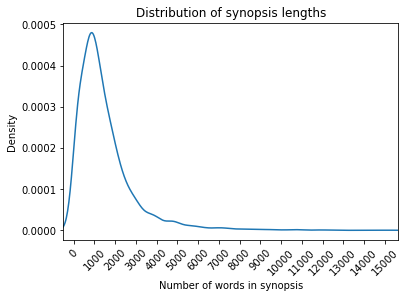

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Distribution of synopsis length (for movies with synopsis). 
# Most synopses are in the range mean synopsis length +- 1000 words (with some synopses with lots of words)
df_syn['synopsis_length'].plot.kde()
plt.xticks(np.arange(0, max_syn_len+1, 1000), rotation=45)
plt.xlim(xmax = max_syn_len+500, xmin = -500)
plt.xlabel("Number of words in synopsis")
plt.title("Distribution of synopsis lengths")
plt.show()

In [10]:
# Create column normalized synopsis_length
df_syn['synopsis_length_norm'] = (df_syn.synopsis_length - min_syn_len)/(max_syn_len - min_syn_len)

In [ ]:
# Determine normalized synopsis statistics
min_syn_len_norm = df_syn.synopsis_length_norm.min()
max_syn_len_norm = df_syn.synopsis_length_norm.max()
mean_syn_len_norm = df_syn.synopsis_length_norm.mean()
median_syn_len_norm = df_syn.synopsis_length_norm.median()

print("Minimum normalized synopsis length is: ", min_syn_len_norm) # min and max is indeed what should be the case with min-max normalization
print("Maximum normalized synopsis length is: ", max_syn_len_norm)
print("Mean normalized synopsis length is: ", "{:.2f}".format(mean_syn_len_norm))
print("Median normalized synopsis length is: ", "{:.2f}".format(median_syn_len_norm))

Minimum normalized synopsis length is:  0.0
Maximum normalized synopsis length is:  1.0
Mean normalized synopsis length is:  0.10
Median normalized synopsis length is:  0.07


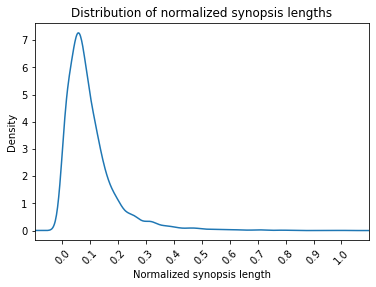

In [ ]:
# MIN-MAX normalisation distribution synopsis lengths
# Shows only a few with very big word count. Most have wordcount around normalized mean +/- .1 (so between .0 and .2)

df_syn['synopsis_length_norm'].plot.kde()
plt.xticks(np.arange(0, max_syn_len_norm+.1, .1), rotation=45)
plt.xlim(xmax = max_syn_len_norm+0.1, xmin = min_syn_len_norm-0.1)
plt.xlabel("Normalized synopsis length")
plt.title("Distribution of normalized synopsis lengths")
plt.show()

In [ ]:
# Check what the word threshold is with different normalized synopsis
threshold_01 = df_syn[df_syn['synopsis_length_norm'] > .01].synopsis_length.min()
threshold_025 = df_syn[df_syn['synopsis_length_norm'] > .025].synopsis_length.min()
threshold_05 = df_syn[df_syn['synopsis_length_norm'] > .05].synopsis_length.min()

print("The minimum word threshold for synopsis is with .01 normalized synopsis lenght: ", threshold_01, " words")
print("The minimum word threshold for synopsis is with .025 normalized synopsis lenght: ", threshold_025, " words")
print("The minimum word threshold for synopsis is with .05 normalized synopsis lenght: ", threshold_05, " words")

The minimum word threshold for synopsis is with .01 normalized synopsis lenght:  154  words
The minimum word threshold for synopsis is with .025 normalized synopsis lenght:  381  words
The minimum word threshold for synopsis is with .05 normalized synopsis lenght:  760  words


In [11]:
# Create column descr_length (in word count)
df_descr['descr_length'] = df_descr.description.apply(lambda x: x[1:-1].split(' '))
df_descr['descr_length'] = df_descr.descr_length.apply(len)

In [12]:
# Determine description length statistics
min_descr_len = df_descr.descr_length.min()
max_descr_len = df_descr.descr_length.max()
mean_descr_len = df_descr.descr_length.mean()
median_descr_len = df_descr.descr_length.median()

print("Minimum description length is: ", min_descr_len, " words")
print("Maximum description length is: ", max_descr_len, " words")
print("Mean description length is: ", "{:.0f}".format(mean_descr_len), " words")
print("Median description length is: ", "{:.0f}".format(median_descr_len), " words")

Minimum description length is:  7  words
Maximum description length is:  898  words
Mean description length is:  117  words
Median description length is:  100  words


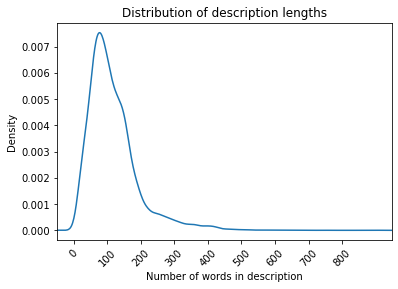

In [ ]:
# Distribution of description length (for movies overall). 
# Most descriptions are in the range mean description length +- 100 words (with some some more words, but generally below 200)
df_descr['descr_length'].plot.kde()
plt.xticks(np.arange(0, max_descr_len, 100), rotation=45)
plt.xlim(xmax = max_descr_len+50, xmin = -50)
plt.xlabel("Number of words in description")
plt.title("Distribution of description lengths")
plt.show()

In [13]:
# Create column normalized description length
df_descr['descr_length_norm'] = (df_descr.descr_length - min_descr_len)/(max_descr_len - min_descr_len)

In [ ]:
# Determine normalized description statistics
min_descr_len_norm = df_descr.descr_length_norm.min()
max_descr_len_norm = df_descr.descr_length_norm.max()
mean_descr_len_norm = df_descr.descr_length_norm.mean()
median_descr_len_norm = df_descr.descr_length_norm.median()

print("Minimum normalized description length is: ", min_descr_len_norm) # min and max is indeed what should be the case with min-max normalization
print("Maximum normalized description length is: ", max_descr_len_norm)
print("Mean normalized description length is: ", "{:.2f}".format(mean_descr_len_norm))
print("Median normalized description length is: ", "{:.2f}".format(median_descr_len_norm))

Minimum normalized description length is:  0.0
Maximum normalized description length is:  1.0
Mean normalized description length is:  0.12
Median normalized description length is:  0.10


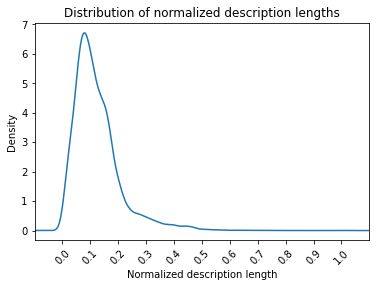

In [ ]:
# MIN-MAX normalisation distribution description lengths
# Shows only a few with big word count. Most have wordcount around normalized mean +/- .1 (so between .0 and .2)
df_descr['descr_length_norm'].plot.kde()
plt.xticks(np.arange(0, max_descr_len_norm+.1, .1), rotation=45)
plt.xlim(xmax = max_descr_len_norm+0.1, xmin = min_descr_len_norm-0.1)
plt.xlabel("Normalized description length")
plt.title("Distribution of normalized description lengths")
plt.show()

In [ ]:
# Check what the word threshold is with different normalized description
threshold_1 = df_descr[df_descr['descr_length_norm'] > .1].descr_length.min()
threshold_2 = df_descr[df_descr['descr_length_norm'] > .2].descr_length.min()
threshold_3 = df_descr[df_descr['descr_length_norm'] > .3].descr_length.min()

print("The minimum word threshold for description is with .1 normalized description lenght: ", threshold_1, " words")
print("The minimum word threshold for description is with .2 normalized description lenght: ", threshold_2, " words")
print("The minimum word threshold for description is with .3 normalized description lenght: ", threshold_3, " words")

The minimum word threshold for description is with .1 normalized description lenght:  97  words
The minimum word threshold for description is with .2 normalized description lenght:  186  words
The minimum word threshold for description is with .3 normalized description lenght:  275  words


Concluding, from the graphs we can see that most of the descriptions have a length under 250 words, with a mean and median around 100 words. Most synopses have a length under 3000 words and above 300 words, with a mean around 1500 words and a median around 1100 words. We can thus safely state that synopses have longer texts than descriptions, and we can say that synopses with lengths under 250 words are more like descriptions so we can exclude these in our analyses.

In [ ]:
# Subset the movies with a minimum synopsis word length threshold
df_syn_250 = df_syn[df_syn['synopsis_length'] > 250]
df_syn_500 = df_syn[df_syn['synopsis_length'] > 500]

In [ ]:
# Check how many of the movies with synopses are left when using a minimum word count threshold
n_syn_250 = len(df_syn_250)
n_syn_500 = len(df_syn_500)

print("The number of movies with synopses of more than 250 words is: ", len(df_syn_250), ", which fraction is ", "{:.2f}".format(n_syn_250/n_syn) , " of the movies with synopses, and ", "{:.2f}".format(n_syn_250/n_movies), " of all movies")
print("The number of movies with synopses of more than 500 words is: ", len(df_syn_500), ", which fraction is ", "{:.2f}".format(n_syn_500/n_syn) , " of the movies with synopses, and ", "{:.2f}".format(n_syn_500/n_movies), " of all movies")

The number of movies with synopses of more than 250 words is:  4631 , which fraction is  0.89  of the movies with synopses, and  0.49  of all movies
The number of movies with synopses of more than 500 words is:  4200 , which fraction is  0.81  of the movies with synopses, and  0.45  of all movies


Above we can see that only 10% of the movies with synopses is excluded with a minimum word count of 250, while this is 10% more with a threshold of 500 words. We will thus indeed use a minimum word count of 250 for including synopses in our model training, as otherwise these synopses could better be classified as a description.

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the number of movies with synopses per year
syn_dict = Counter(df_syn.year)

# Count the number of movies with synopses longer than 250 words per year
syn_250_dict = Counter(df_syn_250.year)

# Count the number of movies with synopses longer than 500 words per year
#syn_500_dict = Counter(df_syn_500.year)

# Count the total number of movies per year
total_dict = Counter(Movies_Bechdel['year'])

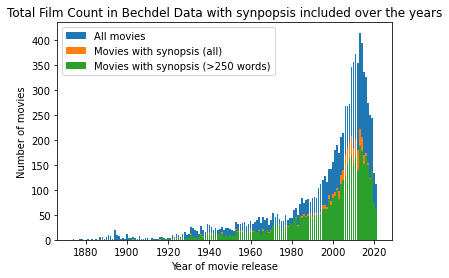

In [ ]:
# Make a plot showing the number of movies with synopses per year compared to the total number of movies in that year
plt.bar(total_dict.keys(), total_dict.values(), label='All movies')
plt.bar(syn_dict.keys(), syn_dict.values(), label='Movies with synopsis (all)')
plt.bar(syn_250_dict.keys(), syn_250_dict.values(), label='Movies with synopsis (>250 words)')
#plt.bar(syn_500_dict.keys(), syn_500_dict.values(), label='Movies with synopsis (>500 words)')
plt.title('Total Film Count in Bechdel Data with synpopsis included over the years')
plt.xlabel('Year of movie release')
plt.ylabel('Number of movies')
plt.legend()
plt.show() # In the white bars there are movies but the plot just makes this regular pattern somehow

In [ ]:
# Determine the fraction of movies per year with synopsis 
# If syn_dict does not contain movies for a key of total_dict (so doesn't contain that key in its dict even), then it will get 0 as fraction
fraction_syn_dict = Counter({k:syn_dict[k]/total_dict[k] for k in total_dict})

# Determine the fraction of movies per year with synopsis longer than 250 words
fraction_syn_250_dict = Counter({k:syn_250_dict[k]/total_dict[k] for k in total_dict})

In [ ]:
# Number of years in dataset
min_year = min(list(fraction_syn_dict.keys()))
max_year = max(list(fraction_syn_dict.keys()))
range_years = max_year - min_year
print("Number of years in dataset: ", range_years, " with minimum ", min_year, " and maximum ", max_year) 

Number of years in dataset:  147  with minimum  1874  and maximum  2021


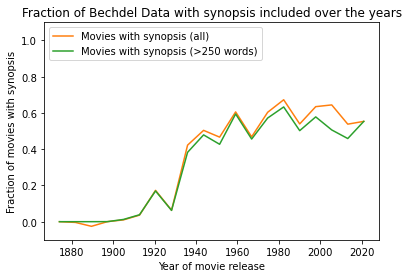

In [ ]:
# Inspired from https://www.statology.org/matplotlib-smooth-curve/
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

# Define x as 50 equally spaced values between the min and max of years (there are 147 years in data)
xnew = np.linspace(min_year, 
                   max_year, 20) 

# Define spline to create smoothed fraction values to plot
spl = make_interp_spline(list(fraction_syn_dict.keys()), list(fraction_syn_dict.values()), k=3)
y_smooth = spl(xnew)

# Define spline for synopses longer than 250 words to create smoothed fraction values to plot
spl_250 = make_interp_spline(list(fraction_syn_250_dict.keys()), list(fraction_syn_250_dict.values()), k=3)
y_smooth_250 = spl_250(xnew)

# Plot the fraction of movies with synopsis per year (higher meaning more movies with this and lower meaning more movies without it)
# So: the later years have more movies with synopsis, after 1940 relatively equal fraction and before 1920 too
# A random spike above 1 or below 0 is due to the smoothing, there is no fraction higher than one or lower than zero when inspecting the data
plt.plot(xnew, y_smooth, label='Movies with synopsis (all)', color = 'tab:orange')
plt.plot(xnew, y_smooth_250, label='Movies with synopsis (>250 words)', color = 'tab:green')
# plt.plot(range(min_year, max_year, 1), [0.5]*range_years) # Add a line stating when there would be a balance between movies with and with synopses (although we strive to a value of 0 for all)
plt.ylim(ymax = 1.1, ymin = -0.1)
plt.title("Fraction of Bechdel Data with synopsis included over the years")
plt.xlabel('Year of movie release')
plt.ylabel('Fraction of movies with synopsis')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Count the number of movies with synopsis per rating
synopsis_rating_dict = Counter(df_syn.rating)

# Count the number of movies with synopsis longer than 250 words per rating
synopsis_250_rating_dict = Counter(df_syn_250.rating)

# Count the total number of movies per rating
total_rating_dict = Counter(Movies_Bechdel['rating'])

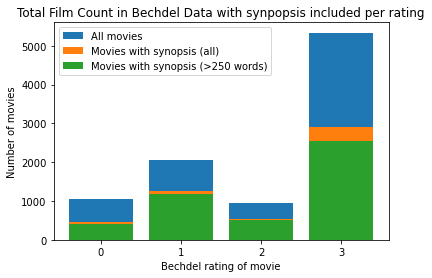

In [ ]:
# Make a plot showing the number of movies with synopses per rating compared to the total number of movies in that rating

# Otherwise the x-axis will show a value range instead of int classes so need to get the values out in an ordered way first,
# and make a list with strings as rating value for the x-axis classes
total_rating_ordered = [total_rating_dict[rating] for rating in [0,1,2,3]]
synopsis_rating_dict_ordered = [synopsis_rating_dict[rating] for rating in [0,1,2,3]]
synopsis_250_rating_dict_ordered = [synopsis_250_rating_dict[rating] for rating in [0,1,2,3]]
ratings_str = [str(rating) for rating in [0,1,2,3]]

plt.bar(ratings_str, total_rating_ordered, label='All movies')
plt.bar(ratings_str, synopsis_rating_dict_ordered, label='Movies with synopsis (all)')
plt.bar(ratings_str, synopsis_250_rating_dict_ordered, label='Movies with synopsis (>250 words)')
plt.title('Total Film Count in Bechdel Data with synpopsis included per rating')
plt.xlabel('Bechdel rating of movie')
plt.ylabel('Number of movies')
plt.legend()
plt.show()

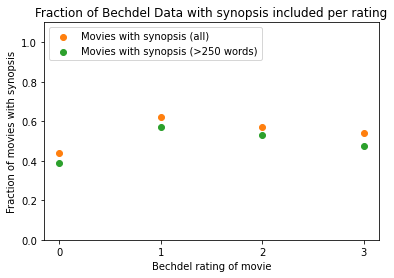

In [ ]:
# Plot the fraction of movies with synopsis per rating
# For this and the same plot for binary rating it is better to just show percentage in table or in the graph above
fraction_rating_ordered = [syn / tot for syn, tot in zip(synopsis_rating_dict_ordered, total_rating_ordered)]
fraction_250_rating_ordered = [syn / tot for syn, tot in zip(synopsis_250_rating_dict_ordered, total_rating_ordered)]

plt.scatter(ratings_str, fraction_rating_ordered, label='Movies with synopsis (all)', color = 'tab:orange')
plt.scatter(ratings_str, fraction_250_rating_ordered, label='Movies with synopsis (>250 words)', color = 'tab:green')

plt.ylim(ymax = 1.1, ymin = 0)
plt.title("Fraction of Bechdel Data with synopsis included per rating")
plt.xlabel('Bechdel rating of movie')
plt.ylabel('Fraction of movies with synopsis')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Print the fraction of movies with synopsis per rating
for rating, fraction in zip(ratings_str, fraction_rating_ordered):
    print("Rating: ", rating, ", fraction with synopsis (all): ", "{:.2f}".format(fraction))

Rating:  0 , fraction with synopsis (all):  0.44
Rating:  1 , fraction with synopsis (all):  0.62
Rating:  2 , fraction with synopsis (all):  0.57
Rating:  3 , fraction with synopsis (all):  0.54


In [ ]:
# Print the fraction of movies with synopsis longer than 250 words per rating
for rating, fraction in zip(ratings_str, fraction_250_rating_ordered):
    print("Rating: ", rating, ", fraction with synopsis (>250 words): ", "{:.2f}".format(fraction))

Rating:  0 , fraction with synopsis (>250 words):  0.39
Rating:  1 , fraction with synopsis (>250 words):  0.57
Rating:  2 , fraction with synopsis (>250 words):  0.53
Rating:  3 , fraction with synopsis (>250 words):  0.48


In [ ]:
# Count the number of movies with synopsis per binary rating
synopsis_binary_rating_dict = Counter(df_syn.Binary_rating)

# Count the number of movies with synopsis longer than 250 words per binary rating
synopsis_250_binary_rating_dict = Counter(df_syn_250.Binary_rating)

# Count the total number of movies per binary rating
total_binary_rating_dict = Counter(Movies_Bechdel['Binary_rating'])

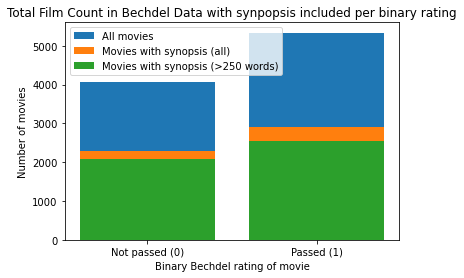

In [ ]:
# Make a plot showing the number of movies with synopses per binary rating compared to the total number of movies in that binary rating

# Otherwise the x-axis will show a value range instead of int classes so need to get the values out in an ordered way first,
# and make a list with strings as rating value for the x-axis classes
total_binary_rating_ordered = [total_binary_rating_dict[rating] for rating in [0,1]]
synopsis_binary_rating_dict_ordered = [synopsis_binary_rating_dict[rating] for rating in [0,1]]
synopsis_250_binary_rating_dict_ordered = [synopsis_250_binary_rating_dict[rating] for rating in [0,1]]
binary_ratings_str = ['Not passed (0)', 'Passed (1)']

plt.bar(binary_ratings_str, total_binary_rating_ordered, label='All movies')
plt.bar(binary_ratings_str, synopsis_binary_rating_dict_ordered, label='Movies with synopsis (all)')
plt.bar(binary_ratings_str, synopsis_250_binary_rating_dict_ordered, label='Movies with synopsis (>250 words)')
plt.title('Total Film Count in Bechdel Data with synpopsis included per binary rating')
plt.xlabel('Binary Bechdel rating of movie')
plt.ylabel('Number of movies')
plt.legend(loc='upper left')
plt.show()

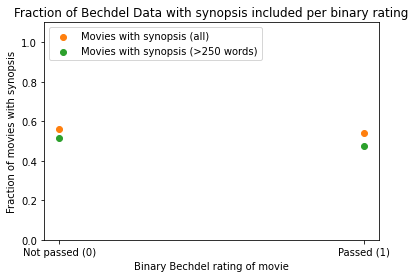

In [ ]:
# Plot the fraction of movies with synopsis per binary rating
fraction_binary_rating_ordered = [syn / tot for syn, tot in zip(synopsis_binary_rating_dict_ordered, total_binary_rating_ordered)]
fraction_250_binary_rating_ordered = [syn / tot for syn, tot in zip(synopsis_250_binary_rating_dict_ordered, total_binary_rating_ordered)]

plt.scatter(binary_ratings_str, fraction_binary_rating_ordered, label='Movies with synopsis (all)', color = 'tab:orange')
plt.scatter(binary_ratings_str, fraction_250_binary_rating_ordered, label='Movies with synopsis (>250 words)', color = 'tab:green')

plt.ylim(ymax = 1.1, ymin = 0)
plt.title("Fraction of Bechdel Data with synopsis included per binary rating")
plt.xlabel('Binary Bechdel rating of movie')
plt.ylabel('Fraction of movies with synopsis')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Print the fraction of movies (with synopsis) that passed the Bechdel test using binary rating
print("Fraction of movies that passed (binary rating 1) of all movies: ", "{:.2f}".format(total_binary_rating_ordered[1] / n_movies))
print("Fraction of movies that passed (binary rating 1) of movies with synopsis (all): ", "{:.2f}".format(synopsis_binary_rating_dict_ordered[1] / n_syn))
print("Fraction of movies that passed (binary rating 1) of movies with synopsis (>250 words): ", "{:.2f}".format(synopsis_250_binary_rating_dict_ordered[1] / n_syn_250))

Fraction of movies that passed (binary rating 1) of all movies:  0.57
Fraction of movies that passed (binary rating 1) of movies with synopsis (all):  0.56
Fraction of movies that passed (binary rating 1) of movies with synopsis (>250 words):  0.55


In [ ]:
# Print the fraction of movies with synopsis per binary rating
for rating, fraction in zip(binary_ratings_str, fraction_binary_rating_ordered):
    print("Binary rating: ", rating, ", fraction with synopsis (all): ", "{:.2f}".format(fraction))

Binary rating:  Not passed (0) , fraction with synopsis (all):  0.56
Binary rating:  Passed (1) , fraction with synopsis (all):  0.54


In [ ]:
# Print the fraction of movies with synopsis longer than 250 words per binary rating
for rating, fraction in zip(binary_ratings_str, fraction_250_binary_rating_ordered):
    print("Binary rating: ", rating, ", fraction with synopsis (>250 words): ", "{:.2f}".format(fraction))

Binary rating:  Not passed (0) , fraction with synopsis (>250 words):  0.51
Binary rating:  Passed (1) , fraction with synopsis (>250 words):  0.48


Because the binary rating is more balanced than the 0-3 rating, and that is the actual objective of the Bechdel test, we will only use that rating for the rest of our analysis. Note that movies with synopsis have similar overall passing values as the dataset on the whole

In [ ]:
# Count the number of movies with synopses per year that passed
pass_syn_dict = Counter(df_syn[df_syn.Binary_rating==1].year)

# Count the number of movies with synopses longer than 250 words per year that passed
pass_syn_250_dict = Counter(df_syn_250[df_syn_250.Binary_rating==1].year)

# Count the total number of movies per year that passed
pass_total_dict = Counter(Movies_Bechdel[Movies_Bechdel.Binary_rating==1].year)

# Determine the fraction of movies per year with synopsis that passed
# If pass_syn_dict does not contain movies for a key of syn_dict (so doesn't contain that key in its dict even), then it will get 0 as fraction
fraction_pass_syn_dict = Counter({k:pass_syn_dict[k]/syn_dict[k] for k in syn_dict})

# Determine the fraction of movies per year with synopsis longer than 250 words that passed
# If pass_syn_dict does not contain movies for a key of syn_dict (so doesn't contain that key in its dict even), then it will get 0 as fraction
fraction_pass_syn_250_dict = Counter({k:pass_syn_250_dict[k]/syn_250_dict[k] for k in syn_250_dict})

# Determine the fraction of all movies per year that passed
# If pass_total_dict does not contain movies for a key of total_dict (so doesn't contain that key in its dict even), then it will get 0 as fraction
fraction_pass_total_dict = Counter({k:pass_total_dict[k]/total_dict[k] for k in total_dict})

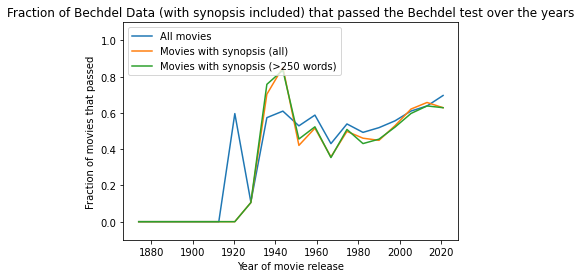

In [ ]:
# Make a plot showing the fraction of movies with synopses that passed the Bechdel test per year 
# compared to the fraction of movies that passed in that year

# Inspired from https://www.statology.org/matplotlib-smooth-curve/

# Define spline to create smoothed fraction of passed values in synopsis data to plot
spl_pass_syn = make_interp_spline(list(fraction_pass_syn_dict.keys()), list(fraction_pass_syn_dict.values()), k=1)
y_smooth_pass_syn = spl_pass_syn(xnew) # xnew is equally spaced over the years, defined before

# Define spline to create smoothed fraction of passed values in synopsis data with text longer than 250 words to plot
spl_pass_syn_250 = make_interp_spline(list(fraction_pass_syn_250_dict.keys()), list(fraction_pass_syn_250_dict.values()), k=1)
y_smooth_pass_syn_250 = spl_pass_syn_250(xnew) # xnew is equally spaced over the years, defined before

# Define spline to create smoothed fraction of passed values in all data to plot
spl_pass_total = make_interp_spline(list(fraction_pass_total_dict.keys()), list(fraction_pass_total_dict.values()), k=1)
y_smooth_pass_total = spl_pass_total(xnew) # xnew is equally spaced over the years, defined before

# Plot the fraction of movies (with synopsis) per year that passed (higher meaning more movies with this and lower meaning more movies without it)
# A random spike above 1 or below 0 is due to the smoothing, there is no fraction higher than one or lower than zero when inspecting the data
plt.plot(xnew, y_smooth_pass_total, label='All movies')
plt.plot(xnew, y_smooth_pass_syn, label='Movies with synopsis (all)')
plt.plot(xnew, y_smooth_pass_syn_250, label='Movies with synopsis (>250 words)')
plt.ylim(ymax = 1.1, ymin = -0.1)
plt.title("Fraction of Bechdel Data (with synopsis included) that passed the Bechdel test over the years")
plt.xlabel('Year of movie release')
plt.ylabel('Fraction of movies that passed')
plt.legend(loc='upper left')
plt.show()

So: over the years a higher percentage of movies passes the Bechdel test but this is leveling out the past decades. Furthermore, overall the fractions between all movies and movies with synopsis is relatively equal, apart from spikes around 1920 and 1945.

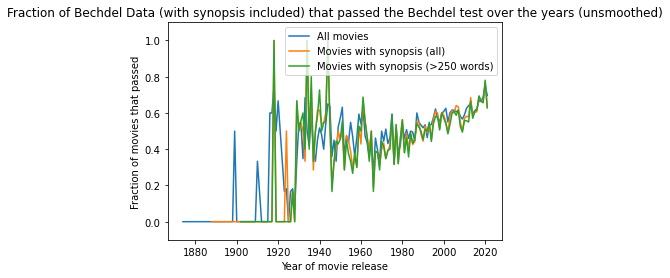

In [ ]:
# Make the same plot as above but then without smoothing to see if it was just one spike that influences the surrounding
# years, but seems to be about multiple years in that range with big differences between fraction of passes
# within all movies and the ones with synopsis
plt.plot(fraction_pass_total_dict.keys(), fraction_pass_total_dict.values(), label='All movies')
plt.plot(fraction_pass_syn_dict.keys(), fraction_pass_syn_dict.values(), label='Movies with synopsis (all)')
plt.plot(fraction_pass_syn_250_dict.keys(), fraction_pass_syn_250_dict.values(), label='Movies with synopsis (>250 words)')
plt.ylim(ymax = 1.1, ymin = -0.1)
plt.title("Fraction of Bechdel Data (with synopsis included) that passed the Bechdel test over the years (unsmoothed)")
plt.xlabel('Year of movie release')
plt.ylabel('Fraction of movies that passed')
plt.legend()
plt.show()

For all plots we can see that movies with synopsis and the subset with synopses longer than 250 words have equal values and hence this subset can be reliably used. This subset has overall similar values as the full set as well, but it is best to restrict ourselves to movies after 1950 because there they align more with the full dataset (before this time there are hardly any movies with synopses so these would otherwise not be correctly represented). 

## Data analysis

After the data gathering and data exploration, we can now analyse it.
We so far have created the following (sub)sets of data:
* Movies_Bechdel: the full dataset of Bechdel movie ratings with their scraped descriptions and synopses
* df_descr: subset of Movies_Bechdel that contain a description (almost similar to Movies_Bechdel), and also includes a column with (normalized) text length of description
* df_syn: subset of Movies_Bechdel that contain a synopsis, and also includes a column with (normalized) text length of synopsis
* df_syn_250: subset of df_syn with movies that have a synopsis of at least 250 words long 
* df_syn_500: subset of df_syn with movies that have a synopsis of at least 500 words long

Because the fraction of movies that pass the Bechdel test is more balanced after 1950 (before almost no passes and almost never a synopsis), we still have to subset on that as well. Due to not wanting to perform duplicate tokenization of movie descriptions or synopses for computational reasons, we will first run this procedure on df_descr and df_syn data, and only after subset the data again on these mentioned sets.

In [ ]:
# Make subsets of movies after 1950 from all the subsets itemized above (apart from the superset Movies_Bechdel).
df_descr_1950 = df_descr[df_descr.year >= 1950]
df_syn_1950 = df_syn[df_syn.year >= 1950]
df_syn_250_1950 = df_syn_250[df_syn_250.year >= 1950]
df_syn_500_1950 = df_syn_500[df_syn_500.year >= 1950]

In [ ]:
# Check the fraction of movies that are left after also subsetting on movies after 1950
n_df_descr_1950 = len(df_descr_1950)
n_df_syn_1950 = len(df_syn_1950)
n_df_syn_250_1950 = len(df_syn_250_1950)
n_df_syn_500_1950 = len(df_syn_500_1950)

print("{:.1f}".format(n_df_descr_1950/n_descr*100), "% of movies with descriptions is from after 1950, which is ", "{:.1f}".format(n_df_descr_1950/n_movies*100), "% of the total number of movies.")
print("{:.1f}".format(n_df_syn_1950/n_syn*100), "% of movies with synopsis is from after 1950, which is ", "{:.1f}".format(n_df_syn_1950/n_movies*100), "% of the total number of movies.")
print("{:.1f}".format(n_df_syn_250_1950/n_syn_250*100), "% of movies with synopsis longer than 250 words is from after 1950, which is ", "{:.1f}".format(n_df_syn_250_1950/n_syn*100), "% of the movies with synopsis, and is ", "{:.1f}".format(n_df_syn_250_1950/n_movies*100), "% of the total number of movies.")
print("{:.1f}".format(n_df_syn_500_1950/n_syn_500*100), "% of movies with synopsis longer than 500 words is from after 1950, which is ", "{:.1f}".format(n_df_syn_500_1950/n_syn*100), "% of the movies with synopsis, and is ", "{:.1f}".format(n_df_syn_500_1950/n_movies*100), "% of the total number of movies.")

92.9 % of movies with descriptions is from after 1950, which is  92.5 % of the total number of movies.
95.8 % of movies with synopsis is from after 1950, which is  52.8 % of the total number of movies.
95.9 % of movies with synopsis longer than 250 words is from after 1950, which is  85.8 % of the movies with synopsis, and is  47.3 % of the total number of movies.
96.2 % of movies with synopsis longer than 500 words is from after 1950, which is  78.0 % of the movies with synopsis, and is  43.0 % of the total number of movies.


### Functions for data analysis

In [56]:
# ! pip install spacy

In [57]:
# ! python -m spacy download en_core_web_sm 

In [97]:
import spacy
import re
from tqdm.auto import tqdm

def tokenize(df_column=None, processed_texts = [], remove_punctuation=True, 
             to_lowercase=True, stop_words=[], word_types=[], to_lemma=True):
    """
    Tokenizes the text entries in df_column using spacy tokenizer 
    and filters this on supplied arguments, or processes the already
    tokenized texts of processed_texts further
    
    Parameters
    ----------
    df_column : pandas Series object (default None)
        Series with texts that need to be tokenized.
        If None is supplied, then processed_texts needs to be given to process that
        one further using the other arguments instead of tokenizing df_column from the start
    processed_texts : list of list of str (default [])
        List of tokenized texts that need to be further processed using the other arguments.
        If this is supplied, then df_column needs to be None
    remove_punctuation : bool (default True)
        Boolean stating if punctuation needs to be removed from the tokenized texts
    to_lowercase : bool (default True)
        Boolean stating if the tokenized texts need to be lowercased
    stop_words : list of str (default [])
        List with (lowercased) stop words to remove from the tokenized texts,
        with the default being no words to remove
    word_types : list of str (default [])
        List with word types to keep from the tokenized texts, which have to be
        one or multiple of the POS tags of Spacy (e.g. see here for examples
        https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/)
    to_lemma : bool (default True)
        Boolean stating if the tokenized texts need to be lemmatized

        
    Returns
    -------
    raw_processed_texts : list of lists of str
        List with a list of tokenized words per data entry in df_column.
        This is a raw processed texts without taking the other arguments into
        account, such that still multiple different processing methods on the tokens can
        be done without needing to tokenize the full df_column anew
    processed_texts : list of lists of str
        List with a list of tokenized words per data entry in df_column. 
        This is the fully processed texts that take all arguments into account
        to reach the desired tokenization result
    """
    # Preprocess dataset using Spacy tokenizer on texts in df_column, unless None is given,
    # then proceed by further processing the already supplied tokenized texts
    if df_column is not None:
        nlp = spacy.load("en_core_web_sm")
        processed_texts = [text for text in tqdm(nlp.pipe(df_column.values, disable=['ner', 'parser']),
                                                      total=len(df_column.values))]  
    
    # Remove spaces that are presented as an empty string 
    processed_texts = [[word for word in processed_text if not word.text.isspace()] 
                       for processed_text in processed_texts]
    
    raw_processed_texts = processed_texts.copy()
    
    # Remove punctuation if wanted
    if remove_punctuation:
        processed_texts = [[word for word in processed_text if not word.is_punct] 
                           for processed_text in processed_texts]
        
    # Remove the given stopwords if the list is not empty
    if stop_words:
        processed_texts = [[word for word in processed_text if not word.text in stop_words] 
                           for processed_text in processed_texts]
        
    # Filter on given word types if the list is not empty, e.g. 
    # proper nouns ('PROPN'), verbs ('VERB'), nouns ('NOUN') and adjectives ('ADJ')  
    if word_types:
        processed_texts = [[word for word in processed_text if word.pos_ in word_types] 
                           for processed_text in processed_texts]
    
    # Keep only lemmatized words if wanted
    if to_lemma:
        processed_texts = [[word.lemma_ for word in processed_text] 
                           for processed_text in processed_texts]
        
    # Lowercase the text if wanted. When it is lemmatized already, then each item is a string so directly
    # apply .lower() on it, and if it still is a token, then need to apply .text.lower().
    # Perform this as last step because the previous steps still require the spacy tokens
    if to_lowercase:
        processed_texts = [[word.lower() if isinstance(word, str) else word.text.lower() for word in processed_text] 
                           for processed_text in processed_texts]
    
    return raw_processed_texts, processed_texts

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def generate_train_test_data(X, y, vectorizer = 'count', MIN_DF=5, MAX_DF=0.75, test_size = 0.2):
    """
    Creates the training and testing data for training e.g. a logistic regression model.
    For this it uses already tokenized texts, which it vectorizes using a count or
    tf-idf vectorizer, and splits into a training and test dataset
    
    Parameters
    ----------
    X : list of lists of str
        List with a list of tokenized words per data entry, which will be vectorized.
        When a count vectorizer is used, make sure to have fully processed the texts
        already, while with the use of a tf-idf vectorizer no stop words etc. have to
        be removed beforehand as these will have a too high document frequency to
        be considered important words
    y : list of int
        List with the binary Bechdel rating per data entry, which are the labels that
        need to be predicted
    vectorizer : str (default 'count')
        String stating which kind of vectorization needs to be applied on X: 
        'count' for count vectorization, which simply counts how often a word occurs
        in each data entry
        'tf-idf' for TF-IDF vectorization, which weights how often a word occurs in
        other data entries as well to reflect how important a word is for a specific data entry
    MIN_DF : int (default 5)
        Minimum document frequency: the word should occur in at least MIN_DF 
        number of data entries
    MAX_DF : double (default 0.75)
        Maximum document frequency: the word should not occur in more than MAX_DF 
        fraction of the data entries
    test_size : double (default 0.2)
        The fraction of data that must be taken as test data
        
    Returns
    -------
    X_train : list of lists of int
        List with the vectorized data entries for the training data set
    X_test : list of lists of int
        List with the vectorized data entries for the test data set
    y_train : list of int
        List with the binary Bechdel rating for the training data set
    y_test : list of int
        List with the binary Bechdel rating for the test data set
    vocabulary : list of str
        List with the unique words occuring in the training dataset 
    """
    # Split the data into train and test sets, to be able to test the model in a later stage
    X_train_str, X_test_str, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    
    # Use a count vectorizer on the already tokenized texts
    if vectorizer == 'count':
        cv_spacy = CountVectorizer(tokenizer= lambda x:x, preprocessor=lambda x:x,
                     min_df=MIN_DF, max_df=MAX_DF) 
        X_train = cv_spacy.fit_transform(X_train_str)
        X_test = cv_spacy.transform(X_test_str)
        vocabulary = cv_spacy.get_feature_names()
        
    # Use a TF-IDF vectorizer on the already tokenized texts
    elif vectorizer == 'tf-idf':
        tfidf = TfidfVectorizer(tokenizer= lambda x:x, preprocessor=lambda x:x,
                                min_df=MIN_DF, max_df=MAX_DF) 
        tfidf.fit(X_train_str) # create the vocabulary
        X_train = tfidf.transform(X_train_str)
        X_test = tfidf.transform(X_test_str)
        vocabulary = tfidf.get_feature_names() # The newer function .get_feature_names_out() needs scikit-learn > 1.0
    else:
        print("Choose one of the vectorization options: 'count' or 'tf-idf'")
        X_train = X_train_str.copy()
        X_test = X_test_str.copy()
        
    return X_train, X_test, y_train, y_test, vocabulary

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def train_test_logistic_regression(X_train, X_test, y_train, y_test, max_iter=100, labels=['0', '1']):
    """
    Trains a logistic regression model on the training data and tests it on the testing
    data. Reports about the performance of the model on the test dataset will directly
    be shown
    
    Parameters
    ----------
    X_train : list of lists of int
        List with the vectorized data entries for the training data set
    X_test : list of lists of int
        List with the vectorized data entries for the test data set
    y_train : list of int
        List with the binary Bechdel rating for the training data set
    y_test : list of int
        List with the binary Bechdel rating for the test data set
    max_iter : int (default 100)
        Maximum number of iterations taken for the model to (try to) converge
    labels : list of str (default ['0', '1'])
        List with the textual labels belonging to the dataset, used
        for interpretability in visualisation of predictions
        
    Returns
    -------
    lr : sklearn.linear_model.LogisticRegression object
        Trained logistic regression model on the training data
    """
    # Train logistic regression model on training data
    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    
    # Test logistic regression model on test data
    y_pred = lr.predict(X_test)
    
    # Print test statistics
    # Classification report with precision, reclass, f1-score, and (weighted/macro) average
    print("Below the classification report of the model is shown:")
    print(classification_report(y_test, y_pred, 
                          target_names=labels))
    
    # Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    df_confusion_matrix = pd.DataFrame(cf_matrix, index=['Labeled '+str(labels[0]), 'Labeled '+str(labels[1])], 
                                       columns=['Predicted '+str(labels[0]), 'Predicted '+str(labels[1])])
    print("\nBelow the confusion matrix of the model is shown:")
    display(df_confusion_matrix)
    
    return lr

In [61]:
# ! pip install wordcloud
# ! pip install nltk

In [62]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(df_coef_word):
    """
    Create and show a wordcloud of the words in coef_word_list
    with word sizes based on the absolute coefficients
    
    Parameters
    ----------
    df_coef_word : pandas Series object 
        Series with coefficients and their corresponding words
        to be shown in a wordcloud
    """
    # Create word cloud object
    wordcloud = WordCloud(width=400, height=200, random_state=1, background_color="white", colormap='Paired') 
    
    # Create a dictionary out of the dataframe, needed for generating the word cloud
    # The keys are the words and the values the coefficient values (used for sizes of words)
    dict_word_coef = dict(zip(df_coef_word.word.values, df_coef_word.coef.values))
    
    # Generate word cloud using the words, and their coefficients for word sizes
    wordcloud.generate_from_frequencies(dict_word_coef)
    
    # Display the word cloud
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [63]:
from nltk.text import Text

# Lambda function to flatten list of lists, from manual
flatten = lambda t : [item for sublist in t for item in sublist]

def interpret_logistic_regression(lr, vocabulary, raw_processed_texts, labels=['0', '1'], 
                                  n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10):
    """
    Interprets the coefficients of a trained logistic regression model
    by showing for the n_coef_context number of positive and negative 
    valued coefficients in which context these occur in the original dataset,
    and by displaying n_coef_wordcloud number of positive and negative valued
    coefficients in wordclouds with their sizes based on their absolute 
    coefficient values 
    
    Parameters
    ----------
    lr : sklearn.linear_model.LogisticRegression object
        Trained logistic regression model on the training data
    vocabulary : list of str
        Vocabulary of words used in the data
    raw_processed_texts : list of lists of str
        List with a list of tokenized words per data entry in the original data.
        This is used to display the context of most important coefficients for 
        how these are used in the data. This should preferably be raw tokenized 
        texts without taking further processing into account (e.g. stop word removal, 
        lemmatization, or word type filtering), such that still the full, more readable 
        context of words can be shown instead of only fully processed context. The
        latter is also accepted to be supplied but then the outputs are less interpretable
    labels : list of str (default ['0', '1'])
        List with the textual labels belonging to the dataset, used
        for interpretability in visualisations
    n_coef_context : int (default 5)
        Number of most positive and negative valued coefficients
        for which to show the use of these words in the context 
        of the original data in df_column
    n_coef_context_matches : int (default 5)
        For the n_coef_context number of words, maximally show this
        number of matches with the original data
    n_coef_wordcloud : int (default 10)
        Number of most positive and negative valued coefficients
        for which to create a wordcloud with their word sizes
        being based on their absolute coefficient values
    """
    # Combine the coefficients of the model with their corresponding words and sort these 
    # based on their coefficient values
    # Get the logistic regression weights
    regression_coefficients = lr.coef_[0] 
    
    # Combine two separate lists of coefficients [1, 2], and vocabulary ['word1', 'word2'] 
    # into one list [[1, 'word1'], [2, 'word2']]
    vocab_coef_combined = list(zip(regression_coefficients, vocabulary)) 

    # Add the coefficients with their corresponding words to a dataframe and sort this 
    # from most positive values to most negative values
    feature_importance = pd.DataFrame(vocab_coef_combined,
                      columns=['coef', 'word'])
    feature_importance.sort_values('coef', ascending=False, inplace=True)
    
    # Display the n_coef_wordcloud most positive coefficients with their words
    # (this will after also be displayed in a wordcloud for visual comparison)
    print("Below the most positive coefficients with their corresponding words are visualised,\n", 
          "which are associated with the label ", labels[1])
    top_coef_word = feature_importance.head(n_coef_wordcloud)
    display(top_coef_word)
    
    # Create a word cloud using these top words
    print("\nFor a visual exploration of these most positive coefficient words, see the word cloud below")
    create_wordcloud(df_coef_word=top_coef_word)
    
    # Display the n_coef_wordcloud most negative coefficients with their words
    # (this will after also be displayed in a wordcloud for visual comparison)
    print("\nBelow the most negative coefficients with their corresponding words are visualised,\n",
          "which are associated with the label ", labels[0])
    bottom_coef_word = feature_importance.tail(n_coef_wordcloud)
    display(bottom_coef_word)
    
    # Create a word cloud using these bottom words
    print("\nFor a visual exploration of these most negative coefficient words, see the word cloud below")
    create_wordcloud(df_coef_word=bottom_coef_word)
    
    # Create a Text object from the original tokenized data to be able to show concordances in it
    texts = Text(flatten([[word if isinstance(word, str) else word.text for word in texts] 
                          for texts in raw_processed_texts]))
    
    # Display for n_coef_context number of most positive coefficients a maximum of 
    # n_coef_context_matches number of usages in the context of the original data
    for coef, word in feature_importance.head(n_coef_context).values:
        print("\nThe coefficient ", word, " with value ", "{:.2f}".format(coef), "occurs in the following contexts: ")
        texts.concordance(word, lines=n_coef_context_matches)
    
    # Display for n_coef_context number of most positive coefficients a maximum of 
    # n_coef_context_matches number of usages in the context of the original data
    for coef, word in feature_importance.tail(n_coef_context).values:
        print("\nThe coefficient ", word, " with value ", "{:.2f}".format(coef), "occurs in the following contexts: ")
        texts.concordance(word, lines=n_coef_context_matches)

In [64]:
def run_analysis(X, y, raw_processed_texts, vectorizer = 'count', MIN_DF=5, MAX_DF=0.75, 
                 test_size = 0.2, max_iter=100, labels=['0', '1'], 
                 n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10):
    """
    Run the full analysis pipeline on tokenized texts by generating the training
    and test dataset from it, training and testing a logistic regression model
    that uses a count or TF-IDF vectorizer, and by interpreting its coefficients
    
    Parameters
    ----------
    X : list of lists of str
        List with a list of tokenized words per data entry, which will be vectorized.
        When a count vectorizer is used, make sure to have fully processed the texts
        already, while with the use of a tf-idf vectorizer no stop words etc. have to
        be removed beforehand as these will have a too high document frequency to
        be considered important words
    y : list of int
        List with the binary Bechdel rating per data entry, which are the labels that
        need to be predicted
    raw_processed_texts : list of lists of str
        List with a list of tokenized words per data entry in the original data.
        This is used to display the context of most important coefficients for 
        how these are used in the data. This should preferably be raw tokenized 
        texts without taking further processing into account (e.g. stop word removal, 
        lemmatization, or word type filtering), such that still the full, more readable 
        context of words can be shown instead of only fully processed context. The
        latter is also accepted to be supplied but then the outputs are less interpretable
    vectorizer : str (default 'count')
        String stating which kind of vectorization needs to be applied on X: 
        'count' for count vectorization, which simply counts how often a word occurs
        in each data entry
        'tf-idf' for TF-IDF vectorization, which weights how often a word occurs in
        other data entries as well to reflect how important a word is for a specific data entry
    MIN_DF : int (default 5)
        Minimum document frequency: the word should occur in at least MIN_DF 
        number of data entries
    MAX_DF : double (default 0.75)
        Maximum document frequency: the word should not occur in more than MAX_DF 
        fraction of the data entries
    test_size : double (default 0.2)
        The fraction of data that must be taken as test data
    max_iter : int (default 100)
        Maximum number of iterations taken for the model to (try to) converge
    labels : list of str (default ['0', '1'])
        List with the textual labels belonging to the dataset, used
        for interpretability in visualisations
    n_coef_context : int (default 5)
        Number of most positive and negative valued coefficients
        for which to show the use of these words in the context 
        of the original data in df_column
    n_coef_context_matches : int (default 5)
        For the n_coef_context number of words, maximally show this
        number of matches with the original data
    n_coef_wordcloud : int (default 10)
        Number of most positive and negative valued coefficients
        for which to create a wordcloud with their word sizes
        being based on their absolute coefficient values
    """
    # Generate training and testing data
    X_train, X_test, y_train, y_test, vocabulary = generate_train_test_data(
        X=X, y=y, vectorizer = vectorizer, MIN_DF=MIN_DF, MAX_DF=MAX_DF, 
        test_size = test_size)
    
    # Train and test logistic regression model
    lr = train_test_logistic_regression(X_train=X_train, X_test=X_test, 
                                                y_train=y_train, y_test=y_test, 
                                                max_iter=max_iter, labels=labels)
    
    # Interpret regression coefficients
    interpret_logistic_regression(lr=lr, vocabulary=vocabulary, 
                              raw_processed_texts=raw_processed_texts, labels=labels, 
                              n_coef_context=n_coef_context, 
                              n_coef_context_matches=n_coef_context_matches, 
                              n_coef_wordcloud=n_coef_wordcloud)

### Preprocess movie descriptions and synopses

In [19]:
from sklearn.feature_extraction import text

# When using stop word removal, then make sure gender words (pronouns) are removed from that list, 
# because these may be meaningful in the light of our research
stop_list = list(text.ENGLISH_STOP_WORDS-{'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself'})

In [20]:
# Tokenize all the descriptions of movies, which can later be subsetted into different sets to compare. 
# This prevents duplicated tokenizing of descriptions when subsets overlap, which would take unneccessary computing power.
# Additionally, raw_processed_descr can be further processed in different preprocessing ways, than is 
# applied on processed_descr below, as it is still the raw tokenized text. These can then also be compared with each other
raw_processed_descr, fully_processed_descr = tokenize(df_column=df_descr.description, processed_texts = [], 
                                                remove_punctuation=True, to_lowercase=True, stop_words=stop_list, 
                                                word_types=['PROPN', 'VERB', 'NOUN', 'ADJ'], to_lemma=True)

  0%|          | 0/9358 [00:00<?, ?it/s]

In [21]:
# Best to perform this step using Google Colab as it may require more memory than available on your local device
# Tokenize all the synopses of movies, which can later be subsetted into different sets to compare. 
# This prevents duplicated tokenizing of synopses when subsets overlap, which would take unneccessary computing power.
# Additionally, raw_processed_syn can be further processed in different preprocessing ways, than is 
# applied on processed_syn below, as it is still the raw tokenized text. These can then also be compared with each other
raw_processed_syn, fully_processed_syn = tokenize(df_column=df_syn.synopsis, processed_texts = [], 
                                                remove_punctuation=True, to_lowercase=True, stop_words=stop_list, 
                                                word_types=['PROPN', 'VERB', 'NOUN', 'ADJ'], to_lemma=True)

  0%|          | 0/5179 [00:00<?, ?it/s]

In [98]:
# Preprocess the raw tokenized synopses with different settings
# Here take the standard settings, so don't filter on word types, but still remove stop words
_, all_word_types_processed_syn = tokenize(df_column=None, processed_texts = raw_processed_syn, 
                                                remove_punctuation=True, to_lowercase=True, stop_words=stop_list, 
                                                word_types=[], to_lemma=True)

In [100]:
# Here take the standard settings, so don't remove stop words, but still filter on word types
_, with_stopwords_processed_syn = tokenize(df_column=None, processed_texts = raw_processed_syn, 
                                                remove_punctuation=True, to_lowercase=True, stop_words=[], 
                                                word_types=['PROPN', 'VERB', 'NOUN', 'ADJ'], to_lemma=True)

In [101]:
# Here take the standard settings, but still filter on word types (now only verb, noun, adj) and remove stop words
_, without_propn_processed_syn = tokenize(df_column=None, processed_texts = raw_processed_syn, 
                                                remove_punctuation=True, to_lowercase=True, stop_words=stop_list, 
                                                word_types=['VERB', 'NOUN', 'ADJ'], to_lemma=True)

In [25]:
# Make a list with the binary Bechdel rating for each description and for each synopsis, which we want to predict
labels = ['Not passed (0)', 'Passed (1)']
y_descr = list(df_descr.Binary_rating.values)
y_syn = list(df_syn.Binary_rating.values)

### Analyse synopsis data

#### All synopses, using count vectorizer on fully tokenized texts

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, stop word removal (except gendered pronouns), word-type filtering with proper nouns, nouns, verbs, and adjectives

Furthermore, the training and test dataset are established using 20% test data, a count vectorizer with min_df=5 and max_df=0.75 is used on the tokenized words, and logistic regression is trained on this

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.59      0.59      0.59       444
    Passed (1)       0.69      0.69      0.69       592

      accuracy                           0.65      1036
     macro avg       0.64      0.64      0.64      1036
  weighted avg       0.65      0.65      0.65      1036


Below the confusion matrix of the model is shown:


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),263,181
Labeled Passed (1),185,407


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
16921,0.632923,wonderful
9778,0.575054,mention
2510,0.550631,charlotte
6543,0.541765,grace
13564,0.536889,self
14478,0.530928,stab
3196,0.525953,connie
2493,0.523372,character
7469,0.505282,husband
8549,0.504395,kitchen



For a visual exploration of these most positive coefficient words, see the word cloud below


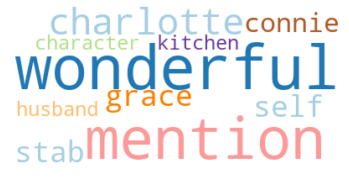


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
633,-0.528273,answer
7876,-0.529123,inspector
2839,-0.529183,closet
8161,-0.532629,japan
4201,-0.534122,devon
6678,-0.547843,grown
8893,-0.553111,levin
1779,-0.591220,boy
12901,-0.605283,rich
15289,-0.824599,term



For a visual exploration of these most negative coefficient words, see the word cloud below


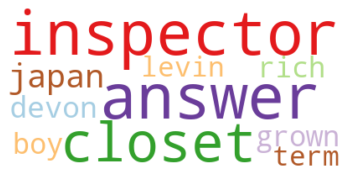


The coefficient  wonderful  with value  0.63 occurs in the following contexts: 
Displaying 5 of 109 matches:
er coasters and hot dogs and has a wonderful time At the end of the evening he 
ld bosses in attendance there is a wonderful scenario where the Underworld boss
e describes her as beautiful and a wonderful person but it s not clear what the
 s the meadow he asked It s a very wonderful place his mother told him Then why
ry You see George you really had a wonderful life Don t you see what a mistake 

The coefficient  mention  with value  0.58 occurs in the following contexts: 
Displaying 5 of 181 matches:
effreys friend and tells him not to mention her investment to Jeffrey That even
 and jewels Sherry warns her not to mention the play in front of Maggie and urg
these attacks Medical ethics not to mention 1945 movie studio sensibilities req
ld survive Lee Hunter interrupts to mention that a herd of Mastadon were thawed
mps back to Earth The film does not mention the thermal barrie

In [67]:
run_analysis(X=fully_processed_syn, y=y_syn, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'count', MIN_DF=5, MAX_DF=0.75, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### All synopses, using TF-IDF vectorizer on fully tokenized texts

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, stop word removal (except gendered pronouns), word-type filtering with proper nouns, nouns, verbs, and adjectives

Furthermore, the training and test dataset are established using 20% test data, a TF-IDF vectorizer with min_df=5 and max_df=0.75 is used on the tokenized words, and logistic regression is trained on this

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.63      0.54      0.58       444
    Passed (1)       0.69      0.77      0.73       592

      accuracy                           0.67      1036
     macro avg       0.66      0.65      0.66      1036
  weighted avg       0.67      0.67      0.67      1036


Below the confusion matrix of the model is shown:


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),240,204
Labeled Passed (1),138,454


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
6406,2.799928,girl
16912,2.206261,woman
5555,2.137313,family
10172,2.097213,mother
13965,2.083176,sister
7469,1.937431,husband
2597,1.899387,child
3823,1.896744,daughter
6543,1.828283,grace
11135,1.778590,parent



For a visual exploration of these most positive coefficient words, see the word cloud below


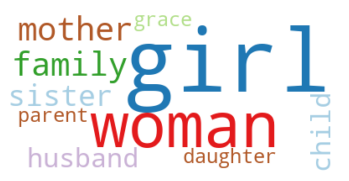


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
7127,-1.058347,henry
3561,-1.065778,crew
824,-1.073974,arthur
8508,-1.083093,kill
3785,-1.105999,danny
11911,-1.136353,prison
6071,-1.165324,fred
11659,-1.210977,police
1779,-2.424013,boy
9365,-3.093509,man



For a visual exploration of these most negative coefficient words, see the word cloud below


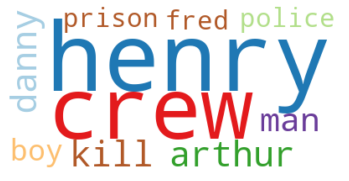


The coefficient  girl  with value  2.80 occurs in the following contexts: 
Displaying 5 of 3318 matches:
 by his wife that he adopts the poor girl Unity lives briefly at Stella Maris 
itting in a garden telling stories A girl Lil Dagover walks past unresponsive 
ted since at that time she was Alans girl friend although she knew that Franci
d some hungry pigeons and kisses his girl Spies are organizing an attempt to s
ritance On the train ride he meets a girl Virginia They are shy to each other 

The coefficient  woman  with value  2.21 occurs in the following contexts: 
Displaying 5 of 4766 matches:
 tells him he wants to marry a white woman but he is then angered when Lynch te
seen by Mrs Vidal an English society woman Later Raffles reappears in London an
ything an attempted murder of an old woman takes place throwing the town into p
ages to leave safely by putting on a woman s dress However a chase ensues He ev
ee dollar box of candy until a young woman arrives searching through the

In [68]:
run_analysis(X=fully_processed_syn, y=y_syn, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=5, MAX_DF=0.75, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### Synopses of movies after 1950, using count vectorizer on fully tokenized texts

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, stop word removal (except gendered pronouns), word-type filtering with proper nouns, nouns, verbs, and adjectives

Furthermore, the training and test dataset are established using 20% test data, a count vectorizer with min_df=5 and max_df=0.75 is used on the tokenized words, and logistic regression is trained on this

In [45]:
# Check the indices of the dataframe with synopses and the tokenized set, which
# are in the exact same order but the df_syn is just not reindexed
print(min(list_indices_syn_1950))
print(max(list_indices_syn_1950))
print(len(fully_processed_syn))

672
9399
5179


In [46]:
# Reindex the all synopses data such that it corresponds to the indices of the
# tokenized texts
df_syn.reset_index(inplace=True)

In [47]:
# Subset the fully processed synopsis data and labels into the movies after 1950
list_indices_syn_1950 = list(df_syn[df_syn.year >= 1950].index.values)
fully_processed_syn_1950 = [fully_processed_syn[i] for i in list_indices_syn_1950]
y_syn_1950 = [y_syn[i] for i in list_indices_syn_1950]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.60      0.60      0.60       442
    Passed (1)       0.68      0.69      0.68       551

      accuracy                           0.65       993
     macro avg       0.64      0.64      0.64       993
  weighted avg       0.65      0.65      0.65       993


Below the confusion matrix of the model is shown:


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),263,179
Labeled Passed (1),172,379


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
16506,0.724199,witch
11631,0.616293,princess
3376,0.609105,couple
2826,0.594294,cocaine
8213,0.591541,karen
8308,0.577631,kid
14905,0.560045,teenage
12750,0.553069,romance
13722,0.552824,sky
3128,0.544657,connie



For a visual exploration of these most positive coefficient words, see the word cloud below


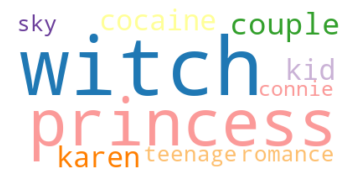


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
2905,-0.514833,colton
16493,-0.516880,wipe
10806,-0.534228,painter
1023,-0.534527,axel
1738,-0.553128,boy
11400,-0.559480,policeman
10631,-0.563312,original
15583,-0.573064,una
7382,-0.589624,ii
14966,-0.606366,term



For a visual exploration of these most negative coefficient words, see the word cloud below


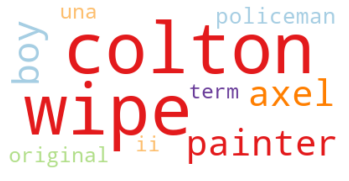


The coefficient  witch  with value  0.72 occurs in the following contexts: 
Displaying 5 of 447 matches:
 party Englehorn says he must be the witch doctor The chief then gets a clear l
orest animals rush home to chase the witch away and she falls to her death but 
 drops Dorothy s house on the Wicked Witch of the East killing her The witch ru
ed Witch of the East killing her The witch ruled the Land of the Munchkins litt
first that Dorothy herself must be a witch The Wicked Witch of the West Margare

The coefficient  princess  with value  0.62 occurs in the following contexts: 
Displaying 5 of 484 matches:
 immediately smitten with a German princess Betty Amann who meets him while re
kward scene Fred tries to kiss the princess who is wearing a harem costume and
face After Fred agrees to meet the Princess in stateroom 19 all numbers he see
ether When Gordon reports that the Princess is a con artist the daughter of a 
his hotel room where she finds the Princess and Fred preparing to lea

In [69]:
run_analysis(X=fully_processed_syn_1950, y=y_syn_1950, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'count', MIN_DF=5, MAX_DF=0.75, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### Synopses of movies after 1950, using TF-IDF vectorizer on fully tokenized texts

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, stop word removal (except gendered pronouns), word-type filtering with proper nouns, nouns, verbs, and adjectives

Furthermore, the training and test dataset are established using 20% test data, a TF-IDF vectorizer with min_df=5 and max_df=0.75 is used on the tokenized words, and logistic regression is trained on this

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.65      0.51      0.57       442
    Passed (1)       0.66      0.78      0.72       551

      accuracy                           0.66       993
     macro avg       0.66      0.64      0.64       993
  weighted avg       0.66      0.66      0.65       993


Below the confusion matrix of the model is shown:


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),225,217
Labeled Passed (1),122,429


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
6263,2.173874,girl
13667,2.051511,sister
9938,2.026829,mother
3728,2.022035,daughter
5417,1.925816,family
7304,1.867672,husband
13110,1.743081,school
8213,1.670741,karen
16528,1.655661,woman
9990,1.649506,mrs



For a visual exploration of these most positive coefficient words, see the word cloud below


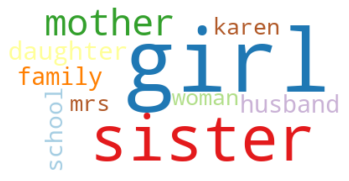


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
11644,-1.084664,prisoner
1186,-1.092506,barry
11643,-1.122755,prison
6967,-1.151477,henry
3694,-1.167271,danny
9184,-1.278642,manny
1459,-1.313206,billy
8088,-1.609822,john
1738,-2.161008,boy
9146,-2.989666,man



For a visual exploration of these most negative coefficient words, see the word cloud below


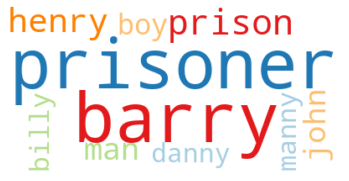


The coefficient  girl  with value  2.17 occurs in the following contexts: 
Displaying 5 of 3318 matches:
 by his wife that he adopts the poor girl Unity lives briefly at Stella Maris 
itting in a garden telling stories A girl Lil Dagover walks past unresponsive 
ted since at that time she was Alans girl friend although she knew that Franci
d some hungry pigeons and kisses his girl Spies are organizing an attempt to s
ritance On the train ride he meets a girl Virginia They are shy to each other 

The coefficient  sister  with value  2.05 occurs in the following contexts: 
Displaying 5 of 1986 matches:
med Harding Georg H Schnell and his sister Ruth Landshoff Hutter kisses his wi
n the beach One day Harding and his sister bring her the letter Hutter wrote w
ing them from his new home Hardings sister falls ill and Ellen watches as a fu
 moves to New York to live with her sister who after the mother s death raises
in the presence of Ulrich s younger sister Hertha Barbara Kent they cut the

In [70]:
run_analysis(X=fully_processed_syn_1950, y=y_syn_1950, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=5, MAX_DF=0.75, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### Synopses of movies after 1950 that are longer than 250 words, using count vectorizer on fully tokenized texts

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, stop word removal (except gendered pronouns), word-type filtering with proper nouns, nouns, verbs, and adjectives

Furthermore, the training and test dataset are established using 20% test data, a count vectorizer with min_df=5 and max_df=0.75 is used on the tokenized words, and logistic regression is trained on this

In [74]:
# Subset the fully processed synopsis data and labels into the movies after 1950 with synopsis lenght larger than 250 words
list_indices_syn_1950_250 = list(df_syn[(df_syn.year >= 1950) & (df_syn.synopsis_length > 250)].index.values)
fully_processed_syn_1950_250 = [fully_processed_syn[i] for i in list_indices_syn_1950_250]
y_syn_1950_250 = [y_syn[i] for i in list_indices_syn_1950_250]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.64      0.57      0.60       423
    Passed (1)       0.64      0.71      0.67       466

      accuracy                           0.64       889
     macro avg       0.64      0.64      0.64       889
  weighted avg       0.64      0.64      0.64       889


Below the confusion matrix of the model is shown:


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),239,184
Labeled Passed (1),135,331


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
9608,0.575857,miriam
8198,0.538588,kid
13244,0.491417,sexual
3683,0.455396,daughter
12179,0.431075,reject
14728,0.430671,teacher
3073,0.427732,connie
9869,0.423820,mrs
2778,0.420104,cocaine
3657,0.396826,dark



For a visual exploration of these most positive coefficient words, see the word cloud below


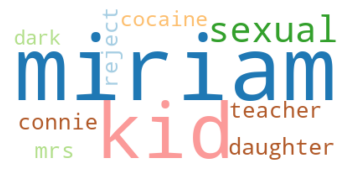


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
16511,-0.378074,yuri
9647,-0.383330,mistake
10978,-0.406212,person
5048,-0.410104,erik
1705,-0.420359,boy
5114,-0.430629,europe
3024,-0.456550,confess
13836,-0.471506,sound
15206,-0.484113,travel
7296,-0.516592,ii



For a visual exploration of these most negative coefficient words, see the word cloud below


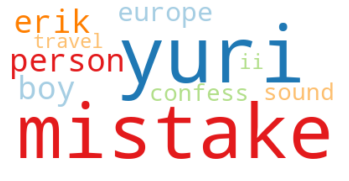


The coefficient  miriam  with value  0.58 occurs in the following contexts: 
Displaying 5 of 173 matches:
falls in love with Margaret Cameron Miriam Cooper during the brothers visit to
vagant Countess De Lave Mary Boland Miriam Aarons Paulette Goddard the tough c
Winston whom she will marry shortly Miriam reveals she has been having an affa
 divorce When Sylvia discovers that Miriam is set to become the new Mrs Fowler
n breaking the fight up ending with Miriam convincing her that she too should 

The coefficient  kid  with value  0.54 occurs in the following contexts: 
Displaying 5 of 580 matches:
habit of his from wearing braces as a kid and Katherine tells Joe that he is st
atherine tells Joe that he is still a kid in many ways Katherine has a gift for
otices that he s being tailed by some kid named Wilmer Cook He confronts the gu
th Thatcher Kane Sr remarked what the kid needs is a good thrashing Mrs Kane re
 s funeral Ann asks his assistant The Kid if Jeff was really going away wi

In [75]:
run_analysis(X=fully_processed_syn_1950_250, y=y_syn_1950_250, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'count', MIN_DF=5, MAX_DF=0.75, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### Synopses of movies after 1950 that are longer than 250 words, using TF-IDF vectorizer on fully tokenized texts

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, stop word removal (except gendered pronouns), word-type filtering with proper nouns, nouns, verbs, and adjectives

Furthermore, the training and test dataset are established using 20% test data, a TF-IDF vectorizer with min_df=5 and max_df=0.75 is used on the tokenized words, and logistic regression is trained on this

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.73      0.52      0.60       423
    Passed (1)       0.65      0.83      0.73       466

      accuracy                           0.68       889
     macro avg       0.69      0.67      0.67       889
  weighted avg       0.69      0.68      0.67       889


Below the confusion matrix of the model is shown:


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),218,205
Labeled Passed (1),80,386


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
6192,2.410332,girl
5354,2.138674,family
9819,2.076947,mother
13533,2.025108,sister
3683,1.757443,daughter
9869,1.658349,mrs
12985,1.572129,school
16355,1.512890,woman
7218,1.469967,husband
10738,1.465580,parent



For a visual exploration of these most positive coefficient words, see the word cloud below


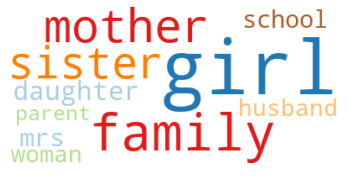


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
16251,-1.047796,wife
797,-1.124041,arthur
2182,-1.141995,carl
3684,-1.151810,dave
11262,-1.161398,police
1172,-1.184931,barry
3647,-1.339009,danny
7993,-1.415468,john
1705,-1.925101,boy
9043,-3.145354,man



For a visual exploration of these most negative coefficient words, see the word cloud below


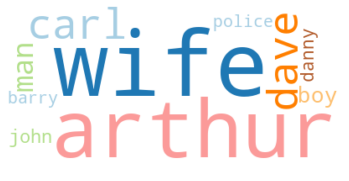


The coefficient  girl  with value  2.41 occurs in the following contexts: 
Displaying 5 of 3318 matches:
 by his wife that he adopts the poor girl Unity lives briefly at Stella Maris 
itting in a garden telling stories A girl Lil Dagover walks past unresponsive 
ted since at that time she was Alans girl friend although she knew that Franci
d some hungry pigeons and kisses his girl Spies are organizing an attempt to s
ritance On the train ride he meets a girl Virginia They are shy to each other 

The coefficient  family  with value  2.14 occurs in the following contexts: 
Displaying 5 of 5260 matches:
eaving his wife with friends of the family a rich shipowner named Harding Geor
e is successful enough to support a family and with his mother s encouragement
irst place One stormy night in 1810 family patriarch John McKay and his rival 
sell at a flea market upsetting his family As the workers begin to fight among
e says goodbye to the child and the family dog They go to the boat and the 

In [76]:
run_analysis(X=fully_processed_syn_1950_250, y=y_syn_1950_250, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=5, MAX_DF=0.75, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### Synopses of movies after 1950 that are longer than 500 words, using count vectorizer on fully tokenized texts

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, stop word removal (except gendered pronouns), word-type filtering with proper nouns, nouns, verbs, and adjectives

Furthermore, the training and test dataset are established using 20% test data, a count vectorizer with min_df=5 and max_df=0.75 is used on the tokenized words, and logistic regression is trained on this

In [77]:
# Subset the fully processed synopsis data and labels into the movies after 1950 with synopsis lenght larger than 500 words
list_indices_syn_1950_500 = list(df_syn[(df_syn.year >= 1950) & (df_syn.synopsis_length > 500)].index.values)
fully_processed_syn_1950_500 = [fully_processed_syn[i] for i in list_indices_syn_1950_500]
y_syn_1950_500 = [y_syn[i] for i in list_indices_syn_1950_500]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.58      0.58      0.58       347
    Passed (1)       0.68      0.68      0.68       462

      accuracy                           0.64       809
     macro avg       0.63      0.63      0.63       809
  weighted avg       0.64      0.64      0.64       809


Below the confusion matrix of the model is shown:


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),202,145
Labeled Passed (1),149,313


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
5270,0.468752,farm
11763,0.461922,rebecca
6322,0.429365,ground
7064,0.423311,husband
3612,0.415602,daughter
11988,0.402602,remain
7648,0.397652,isla
10543,0.386016,parent
5248,0.374982,family
13274,0.366241,sister



For a visual exploration of these most positive coefficient words, see the word cloud below


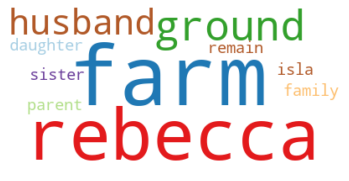


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
369,-0.357346,albert
16210,-0.365072,yuri
12598,-0.371303,salvatore
10747,-0.375110,perfect
2610,-0.379449,claude
11300,-0.384933,prisoner
4813,-0.397038,encounter
600,-0.397443,answer
15073,-0.401427,twin
8522,-0.475687,list



For a visual exploration of these most negative coefficient words, see the word cloud below


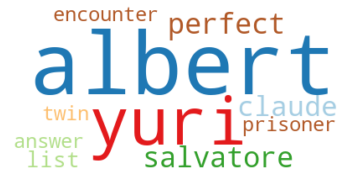


The coefficient  farm  with value  0.47 occurs in the following contexts: 
Displaying 5 of 542 matches:
 how money lenders are stripping the farm while the wife sits alone Another fl
ne He nods assent She says Sell your farm and come with me to the city The Man
oman from the City plots selling the farm through a newspaper ad The couple go
me Soon they are sailing back to the farm under the moonlight They drift peace
nd then a Man who has a cat breeding farm nothing useful comes out of it excep

The coefficient  rebecca  with value  0.46 occurs in the following contexts: 
Displaying 5 of 413 matches:
 Horace Femm an hysteric his sister Rebecca a religious fanatic and Morgan thei
rves her former bedroom as a shrine Rebecca s sleazy cousin Jack Favell George 
husband The continuous reminders of Rebecca overwhelm her she believes that Max
 Maxim is still deeply in love with Rebecca She also discovers that her husband
hold a costume party as he did with Rebecca The heroine tries to plan he

In [78]:
run_analysis(X=fully_processed_syn_1950_500, y=y_syn_1950_500, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'count', MIN_DF=5, MAX_DF=0.75, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### Synopses of movies after 1950 that are longer than 500 words, using TF-IDF vectorizer on fully tokenized texts

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, stop word removal (except gendered pronouns), word-type filtering with proper nouns, nouns, verbs, and adjectives

Furthermore, the training and test dataset are established using 20% test data, a TF-IDF vectorizer with min_df=5 and max_df=0.75 is used on the tokenized words, and logistic regression is trained on this

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.67      0.60      0.63       347
    Passed (1)       0.72      0.77      0.75       462

      accuracy                           0.70       809
     macro avg       0.69      0.69      0.69       809
  weighted avg       0.70      0.70      0.70       809


Below the confusion matrix of the model is shown:


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),209,138
Labeled Passed (1),104,358


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
9621,2.598188,mother
13274,1.943627,sister
5248,1.881244,family
403,1.774384,alice
7963,1.689465,kate
9671,1.687349,mrs
6201,1.674201,grace
3612,1.590370,daughter
7064,1.509148,husband
577,1.495675,anna



For a visual exploration of these most positive coefficient words, see the word cloud below


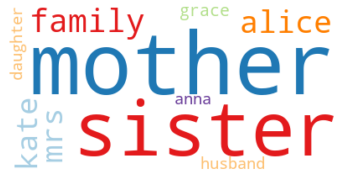


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
4270,-0.934348,doc
8895,-0.943602,manny
1703,-0.987863,brandon
11643,-1.009008,rambo
2146,-1.179885,carl
369,-1.279148,albert
778,-1.303315,arthur
7835,-1.366523,john
1673,-1.594637,boy
8857,-2.850460,man



For a visual exploration of these most negative coefficient words, see the word cloud below


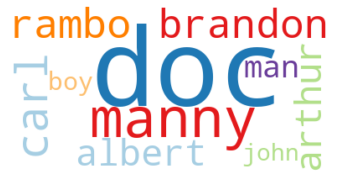


The coefficient  mother  with value  2.60 occurs in the following contexts: 
Displaying 5 of 6179 matches:
re as a nurse Elsie takes Cameron s mother who had traveled to Washington to t
nce on the perfidious advice of his mother and a modern story in which a young
 she is going to live with a loving mother Instead the abusive Louise uses her
he actor is behind bars in jail His mother and his girlfriend Mildred are cons
gh to support a family and with his mother s encouragement takes a train to jo

The coefficient  sister  with value  1.94 occurs in the following contexts: 
Displaying 5 of 1986 matches:
med Harding Georg H Schnell and his sister Ruth Landshoff Hutter kisses his wi
n the beach One day Harding and his sister bring her the letter Hutter wrote w
ing them from his new home Hardings sister falls ill and Ellen watches as a fu
 moves to New York to live with her sister who after the mother s death raises
in the presence of Ulrich s younger sister Hertha Barbara Kent they cut t

In [79]:
run_analysis(X=fully_processed_syn_1950_500, y=y_syn_1950_500, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=5, MAX_DF=0.75, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### Synopses of movies after 1950 that are longer than 500 words, using TF-IDF vectorizer on tokenized texts without stop word removal

Because training on TF-IDF gives better f1-scores for all subsets of data (apart from sometimes being at the expense of predicting not passing incorrectly), we will continue trying to improve a model using such a vectorizer. On all f1-scores this model trained on synopses of movies after 1950 that are longer than 500 words performed the best, so in specific this model will be further assessed. This is also in line with our data exploration that stated that the data is more balanced after 1950, and that synopses shorter than 250 words (or below 500 for some margin) are the same length as descriptions.

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, word-type filtering with proper nouns, nouns, verbs, and adjectives, but no stop word removal

Furthermore, the training and test dataset are established using 20% test data, a TF-IDF vectorizer with min_df=5 and max_df=0.75 is used on the tokenized words, and logistic regression is trained on this

In [104]:
# Subset the processed synopsis data that includes stop words to the movies after 1950 with synopsis lenght larger than 500 words
with_stopwords_processed_syn_1950_500 = [with_stopwords_processed_syn[i] for i in list_indices_syn_1950_500]

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.67      0.61      0.64       347
    Passed (1)       0.73      0.78      0.75       462

      accuracy                           0.71       809
     macro avg       0.70      0.69      0.70       809
  weighted avg       0.70      0.71      0.70       809


Below the confusion matrix of the model is shown:


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),211,136
Labeled Passed (1),102,360


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
9629,2.595104,mother
13288,1.940411,sister
5253,1.880224,family
406,1.779261,alice
7967,1.688036,kate
9679,1.683865,mrs
6205,1.677286,grace
3615,1.589835,daughter
7068,1.511986,husband
580,1.501232,anna



For a visual exploration of these most positive coefficient words, see the word cloud below


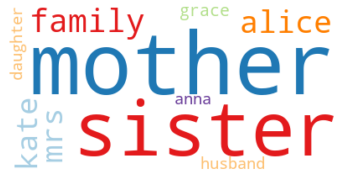


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
8901,-0.948757,manny
1707,-0.989059,brandon
5466,-1.002454,fire
11653,-1.006537,rambo
2149,-1.181783,carl
372,-1.277476,albert
781,-1.303560,arthur
7839,-1.361722,john
1677,-1.597728,boy
8863,-2.834171,man



For a visual exploration of these most negative coefficient words, see the word cloud below


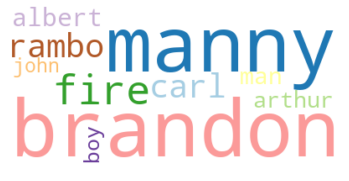


The coefficient  mother  with value  2.60 occurs in the following contexts: 
Displaying 5 of 6179 matches:
re as a nurse Elsie takes Cameron s mother who had traveled to Washington to t
nce on the perfidious advice of his mother and a modern story in which a young
 she is going to live with a loving mother Instead the abusive Louise uses her
he actor is behind bars in jail His mother and his girlfriend Mildred are cons
gh to support a family and with his mother s encouragement takes a train to jo

The coefficient  sister  with value  1.94 occurs in the following contexts: 
Displaying 5 of 1986 matches:
med Harding Georg H Schnell and his sister Ruth Landshoff Hutter kisses his wi
n the beach One day Harding and his sister bring her the letter Hutter wrote w
ing them from his new home Hardings sister falls ill and Ellen watches as a fu
 moves to New York to live with her sister who after the mother s death raises
in the presence of Ulrich s younger sister Hertha Barbara Kent they cut t

In [105]:
run_analysis(X=with_stopwords_processed_syn_1950_500, y=y_syn_1950_500, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=5, MAX_DF=0.75, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### Synopses of movies after 1950 that are longer than 500 words, using TF-IDF vectorizer on tokenized texts without word type filtering

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, stop word removal, but no word-type filtering

Furthermore, the training and test dataset are established using 20% test data, a TF-IDF vectorizer with min_df=5 and max_df=0.75 is used on the tokenized words, and logistic regression is trained on this

In [106]:
# Subset the processed synopsis data that includes all word types to the movies after 1950 with synopsis lenght larger than 500 words
all_word_types_processed_syn_1950_500 = [all_word_types_processed_syn[i] for i in list_indices_syn_1950_500]

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.68      0.60      0.64       347
    Passed (1)       0.72      0.78      0.75       462

      accuracy                           0.71       809
     macro avg       0.70      0.69      0.69       809
  weighted avg       0.70      0.71      0.70       809


Below the confusion matrix of the model is shown:


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),209,138
Labeled Passed (1),100,362


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
10330,2.577026,mother
14166,1.942821,sister
5734,1.892986,family
660,1.771949,alice
8615,1.690046,kate
10382,1.665699,mrs
6738,1.660158,grace
4010,1.581571,daughter
7656,1.500205,husband
2815,1.486989,child



For a visual exploration of these most positive coefficient words, see the word cloud below


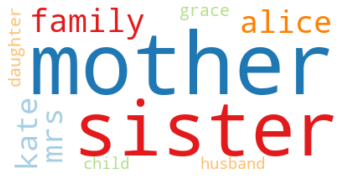


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
9578,-0.939671,manny
4696,-0.945857,doc
2041,-0.983892,brandon
12469,-1.000707,rambo
2496,-1.187210,carl
626,-1.272257,albert
1077,-1.296664,arthur
8481,-1.368862,john
2011,-1.571960,boy
9537,-2.829869,man



For a visual exploration of these most negative coefficient words, see the word cloud below


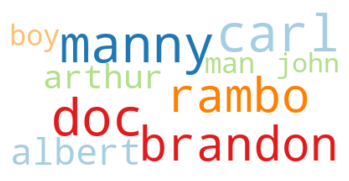


The coefficient  mother  with value  2.58 occurs in the following contexts: 
Displaying 5 of 6179 matches:
re as a nurse Elsie takes Cameron s mother who had traveled to Washington to t
nce on the perfidious advice of his mother and a modern story in which a young
 she is going to live with a loving mother Instead the abusive Louise uses her
he actor is behind bars in jail His mother and his girlfriend Mildred are cons
gh to support a family and with his mother s encouragement takes a train to jo

The coefficient  sister  with value  1.94 occurs in the following contexts: 
Displaying 5 of 1986 matches:
med Harding Georg H Schnell and his sister Ruth Landshoff Hutter kisses his wi
n the beach One day Harding and his sister bring her the letter Hutter wrote w
ing them from his new home Hardings sister falls ill and Ellen watches as a fu
 moves to New York to live with her sister who after the mother s death raises
in the presence of Ulrich s younger sister Hertha Barbara Kent they cut t

In [107]:
run_analysis(X=all_word_types_processed_syn_1950_500, y=y_syn_1950_500, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=5, MAX_DF=0.75, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### Synopses of movies after 1950 that are longer than 500 words, using TF-IDF vectorizer on tokenized texts without proper nouns

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, stop word removal, and word-type filtering with nouns, verbs, and adjectives (so no proper nouns)

Furthermore, the training and test dataset are established using 20% test data, a TF-IDF vectorizer with min_df=5 and max_df=0.75 is used on the tokenized words, and logistic regression is trained on this

In [108]:
# Subset the processed synopsis data that includes stop words to the movies after 1950 with synopsis lenght larger than 500 words
without_propn_processed_syn_1950_500 = [without_propn_processed_syn[i] for i in list_indices_syn_1950_500]

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.65      0.63      0.64       347
    Passed (1)       0.73      0.75      0.74       462

      accuracy                           0.70       809
     macro avg       0.69      0.69      0.69       809
  weighted avg       0.70      0.70      0.70       809


Below the confusion matrix of the model is shown:


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),220,127
Labeled Passed (1),117,345


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
9427,2.517803,sister
6689,2.501704,mother
5152,2.472373,husband
3894,2.303021,family
2614,2.293296,daughter
4489,2.118246,girl
1721,2.030146,child
11597,1.809254,woman
9028,1.794880,school
5098,1.687975,house



For a visual exploration of these most positive coefficient words, see the word cloud below


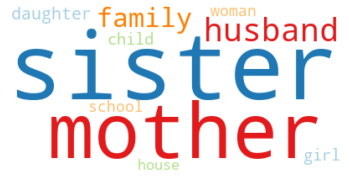


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
7919,-1.010235,prison
1677,-1.015522,chase
4713,-1.020843,guy
10538,-1.030712,thug
11539,-1.068616,wife
7920,-1.136832,prisoner
4401,-1.165464,gang
464,-1.218793,ape
1204,-2.218142,boy
6252,-2.882186,man



For a visual exploration of these most negative coefficient words, see the word cloud below


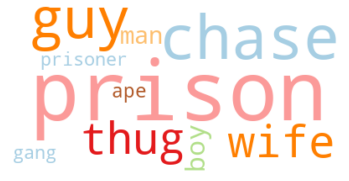


The coefficient  sister  with value  2.52 occurs in the following contexts: 
Displaying 5 of 1986 matches:
med Harding Georg H Schnell and his sister Ruth Landshoff Hutter kisses his wi
n the beach One day Harding and his sister bring her the letter Hutter wrote w
ing them from his new home Hardings sister falls ill and Ellen watches as a fu
 moves to New York to live with her sister who after the mother s death raises
in the presence of Ulrich s younger sister Hertha Barbara Kent they cut their 

The coefficient  mother  with value  2.50 occurs in the following contexts: 
Displaying 5 of 6179 matches:
re as a nurse Elsie takes Cameron s mother who had traveled to Washington to t
nce on the perfidious advice of his mother and a modern story in which a young
 she is going to live with a loving mother Instead the abusive Louise uses her
he actor is behind bars in jail His mother and his girlfriend Mildred are cons
gh to support a family and with his mother s encouragement takes a train 

In [109]:
run_analysis(X=without_propn_processed_syn_1950_500, y=y_syn_1950_500, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=5, MAX_DF=0.75, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### Synopses of movies after 1950 that are longer than 500 words, using TF-IDF vectorizer on tokenized texts without proper nouns and with using different min_df and max_df values

There is basically no difference between f1-scores between the different preprocessing variants of synopses of movies after 1950 that are longer than 500 words and using tf-idf vectorizer. 

When using tf-idf, stop words don't strictly have to be removed as these will get a low relevance due to occuring often, but removing them also doesn't make the model perform significantly different. So, for the sake of computational efficiency we will keep removing these. 

Filtering on some word types also doesn't make the model perform significantly different overall, so we will filter again for the sake of computational efficiency. There is also almost no difference in overall model performance between also filtering on proper nouns, or only on verbs, nouns and adjectives (f1-score of not passing increases by 0.01 and f1-score of passing decreases by 0.01, which is favourable but not that significant on first glance). There is a difference though in the top and bottom words corresponding to the most positive and most negative coefficients, as these will contain names of actors or characters when proper nouns are included. In specific these names that are indicative for passing ratings are femine names, and the ones that are indicative for failing ratings are masculine names. There are thus no gender neutral names or names that are used for multiple genders in between these most indicative names. And because movies often base their characters on stereotypes, it is likely that such very feminine and masculine names are also belonging to people with respectively a female or male gender, not to people who are non-binary for example (such gender diversity is anyways rarely shown in movies). Hence, these names don't seem to influence the overall accuracy of the model in an unexpected or unwanted way. 

Still, we have to look a bit deeper than the overall f1-scores to now make a decision on wheter to include or exclude proper nouns when these overall don't seem to make the model perform much different. For our model it is most important to predict not passing correctly, so to reduce the number of movies that are incorrectly predicted as passing the Bechdel test. This is because the movies that don't pass the test are encouraged to improve themselves, while if these plots seem okay then less efforts will be put into making the movie more inclusive while this would actually be needed. Therefore, a higher recall is more important than a higher precision for the not passing label. For these numbers we see that excluding proper nouns actually increases the recall by 0.03 and decreases the precision by 0.02, so this tiny increase in overall f1-score for the not passing label actually does have a favourable effect in the balance of precision and recall. In the confusion matrix we can also see that when excluding proper nouns there are 127 movies of the test dataset incorrectly predicted to pass, while when this is included there are still 138 movies incorrectly predicted to pass (of 347 movies in the test dataset with not passing label). Thus, we will remove them and tweak the min_df and max_df a bit more for its tokenized texts set to avoid overfitting. 

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, stop word removal, and word-type filtering with nouns, verbs, and adjectives (so without proper nouns)

Furthermore, the training and test dataset are established using 20% test data, a TF-IDF vectorizer with multiple different min_df and max_df is used on the tokenized words, and logistic regression is trained on this

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.66      0.64      0.65       347
    Passed (1)       0.73      0.76      0.74       462

      accuracy                           0.70       809
     macro avg       0.70      0.70      0.70       809
  weighted avg       0.70      0.70      0.70       809


Below the confusion matrix of the model is shown:


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),221,126
Labeled Passed (1),113,349


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
16491,2.523595,mother
23389,2.494452,sister
12439,2.333478,husband
9315,2.276515,family
6290,2.250853,daughter
10828,2.197163,girl
4291,1.999777,child
22421,1.804300,school
29047,1.768149,woman
12297,1.732560,house



For a visual exploration of these most positive coefficient words, see the word cloud below


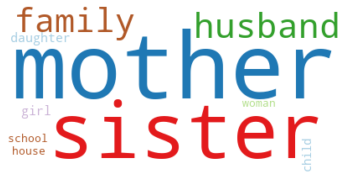


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
14791,-0.958272,list
19760,-0.967065,prison
26072,-0.987625,thug
28878,-1.044964,wife
11383,-1.077200,guy
19761,-1.118414,prisoner
10569,-1.189126,gang
1132,-1.206196,ape
3037,-2.181758,boy
15315,-2.886920,man



For a visual exploration of these most negative coefficient words, see the word cloud below


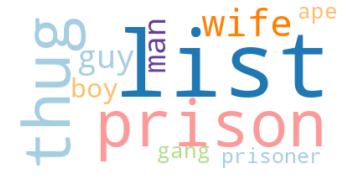


The coefficient  mother  with value  2.52 occurs in the following contexts: 
Displaying 5 of 6179 matches:
re as a nurse Elsie takes Cameron s mother who had traveled to Washington to t
nce on the perfidious advice of his mother and a modern story in which a young
 she is going to live with a loving mother Instead the abusive Louise uses her
he actor is behind bars in jail His mother and his girlfriend Mildred are cons
gh to support a family and with his mother s encouragement takes a train to jo

The coefficient  sister  with value  2.49 occurs in the following contexts: 
Displaying 5 of 1986 matches:
med Harding Georg H Schnell and his sister Ruth Landshoff Hutter kisses his wi
n the beach One day Harding and his sister bring her the letter Hutter wrote w
ing them from his new home Hardings sister falls ill and Ellen watches as a fu
 moves to New York to live with her sister who after the mother s death raises
in the presence of Ulrich s younger sister Hertha Barbara Kent they cut t

In [133]:
# Run analysis with min_df = 0 (instead of 5), and max_df = 1 (instead of 0.75) --> tiny bit better w.r.t. not passing label than defaults of function
run_analysis(X=without_propn_processed_syn_1950_500, y=y_syn_1950_500, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=0, MAX_DF=1.0, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.66      0.64      0.65       347
    Passed (1)       0.74      0.75      0.74       462

      accuracy                           0.70       809
     macro avg       0.70      0.70      0.70       809
  weighted avg       0.70      0.70      0.70       809


Below the confusion matrix of the model is shown:


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),222,125
Labeled Passed (1),114,348


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
9431,2.524436,sister
6692,2.517612,mother
5153,2.449338,husband
3894,2.297416,family
2614,2.275674,daughter
4489,2.110209,girl
1721,2.050903,child
11605,1.808801,woman
9032,1.775727,school
5099,1.686498,house



For a visual exploration of these most positive coefficient words, see the word cloud below


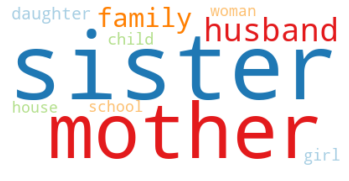


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
1677,-1.011145,chase
7922,-1.015673,prison
10544,-1.023148,thug
4714,-1.050587,guy
11547,-1.069389,wife
7923,-1.131689,prisoner
4401,-1.167619,gang
464,-1.218157,ape
1204,-2.214817,boy
6255,-2.919739,man



For a visual exploration of these most negative coefficient words, see the word cloud below


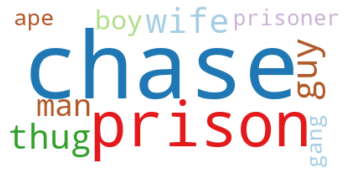


The coefficient  sister  with value  2.52 occurs in the following contexts: 
Displaying 5 of 1986 matches:
med Harding Georg H Schnell and his sister Ruth Landshoff Hutter kisses his wi
n the beach One day Harding and his sister bring her the letter Hutter wrote w
ing them from his new home Hardings sister falls ill and Ellen watches as a fu
 moves to New York to live with her sister who after the mother s death raises
in the presence of Ulrich s younger sister Hertha Barbara Kent they cut their 

The coefficient  mother  with value  2.52 occurs in the following contexts: 
Displaying 5 of 6179 matches:
re as a nurse Elsie takes Cameron s mother who had traveled to Washington to t
nce on the perfidious advice of his mother and a modern story in which a young
 she is going to live with a loving mother Instead the abusive Louise uses her
he actor is behind bars in jail His mother and his girlfriend Mildred are cons
gh to support a family and with his mother s encouragement takes a train 

In [137]:
# Run analysis with min_df = 5, and max_df = 1 (instead of 0.75) --> same results as min_df = 0 and max_df = 1
run_analysis(X=without_propn_processed_syn_1950_500, y=y_syn_1950_500, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=5, MAX_DF=1.0, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.66      0.64      0.65       347
    Passed (1)       0.74      0.75      0.74       462

      accuracy                           0.70       809
     macro avg       0.70      0.70      0.70       809
  weighted avg       0.70      0.70      0.70       809


Below the confusion matrix of the model is shown:


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),222,125
Labeled Passed (1),114,348


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
9431,2.524436,sister
6692,2.517612,mother
5153,2.449338,husband
3894,2.297416,family
2614,2.275674,daughter
4489,2.110209,girl
1721,2.050903,child
11605,1.808801,woman
9032,1.775727,school
5099,1.686498,house



For a visual exploration of these most positive coefficient words, see the word cloud below


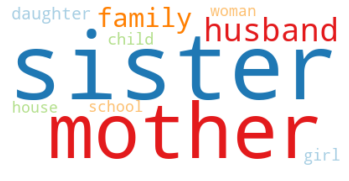


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
1677,-1.011145,chase
7922,-1.015673,prison
10544,-1.023148,thug
4714,-1.050587,guy
11547,-1.069389,wife
7923,-1.131689,prisoner
4401,-1.167619,gang
464,-1.218157,ape
1204,-2.214817,boy
6255,-2.919739,man



For a visual exploration of these most negative coefficient words, see the word cloud below


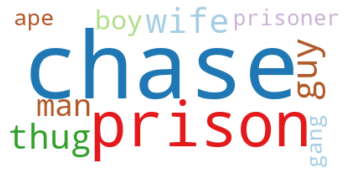


The coefficient  sister  with value  2.52 occurs in the following contexts: 
Displaying 5 of 1986 matches:
med Harding Georg H Schnell and his sister Ruth Landshoff Hutter kisses his wi
n the beach One day Harding and his sister bring her the letter Hutter wrote w
ing them from his new home Hardings sister falls ill and Ellen watches as a fu
 moves to New York to live with her sister who after the mother s death raises
in the presence of Ulrich s younger sister Hertha Barbara Kent they cut their 

The coefficient  mother  with value  2.52 occurs in the following contexts: 
Displaying 5 of 6179 matches:
re as a nurse Elsie takes Cameron s mother who had traveled to Washington to t
nce on the perfidious advice of his mother and a modern story in which a young
 she is going to live with a loving mother Instead the abusive Louise uses her
he actor is behind bars in jail His mother and his girlfriend Mildred are cons
gh to support a family and with his mother s encouragement takes a train 

In [136]:
# Run analysis with min_df = 5, and max_df = 0.9 (instead of 0.75) --> same results as max_df=1
run_analysis(X=without_propn_processed_syn_1950_500, y=y_syn_1950_500, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=5, MAX_DF=0.9, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.66      0.63      0.65       347
    Passed (1)       0.73      0.76      0.75       462

      accuracy                           0.70       809
     macro avg       0.70      0.70      0.70       809
  weighted avg       0.70      0.70      0.70       809


Below the confusion matrix of the model is shown:


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),219,128
Labeled Passed (1),111,351


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
6674,2.538946,mother
9408,2.527450,sister
5141,2.482712,husband
2609,2.275900,daughter
3887,2.273478,family
4480,2.164727,girl
1717,2.056388,child
9010,1.851749,school
5087,1.724860,house
11574,1.574053,woman



For a visual exploration of these most positive coefficient words, see the word cloud below


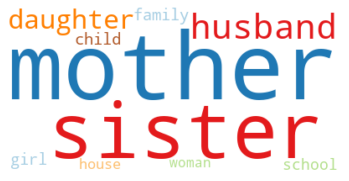


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
440,-1.009808,answer
3538,-1.012854,enemy
1673,-1.025899,chase
10519,-1.041076,thug
4703,-1.074153,guy
4393,-1.135674,gang
11516,-1.169327,wife
7905,-1.194633,prisoner
464,-1.232218,ape
1201,-2.248272,boy



For a visual exploration of these most negative coefficient words, see the word cloud below


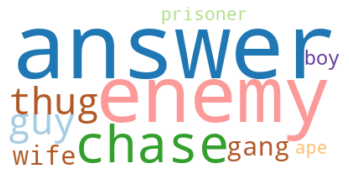


The coefficient  mother  with value  2.54 occurs in the following contexts: 
Displaying 5 of 6179 matches:
re as a nurse Elsie takes Cameron s mother who had traveled to Washington to t
nce on the perfidious advice of his mother and a modern story in which a young
 she is going to live with a loving mother Instead the abusive Louise uses her
he actor is behind bars in jail His mother and his girlfriend Mildred are cons
gh to support a family and with his mother s encouragement takes a train to jo

The coefficient  sister  with value  2.53 occurs in the following contexts: 
Displaying 5 of 1986 matches:
med Harding Georg H Schnell and his sister Ruth Landshoff Hutter kisses his wi
n the beach One day Harding and his sister bring her the letter Hutter wrote w
ing them from his new home Hardings sister falls ill and Ellen watches as a fu
 moves to New York to live with her sister who after the mother s death raises
in the presence of Ulrich s younger sister Hertha Barbara Kent they cut t

In [138]:
# Run analysis with min_df = 5, and max_df = 0.6 (instead of 0.75) --> wrt max_df=0.9 or 1.0, 
# tiny improvement in f1-score of passing label, but balance in precision and recall is less favourable the higher ones
run_analysis(X=without_propn_processed_syn_1950_500, y=y_syn_1950_500, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=5, MAX_DF=0.6, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.62      0.62      0.62       347
    Passed (1)       0.72      0.72      0.72       462

      accuracy                           0.68       809
     macro avg       0.67      0.67      0.67       809
  weighted avg       0.68      0.68      0.68       809


Below the confusion matrix of the model is shown:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),216,131
Labeled Passed (1),131,331


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
309,2.807366,husband
559,2.752111,sister
396,2.543409,mother
159,2.447850,daughter
228,2.272086,family
266,2.104066,girl
680,1.978301,woman
109,1.977568,child
527,1.694702,school
156,1.537002,dance



For a visual exploration of these most positive coefficient words, see the word cloud below


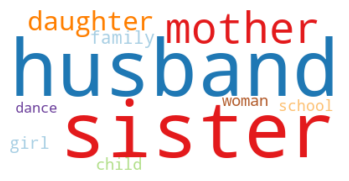


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
265,-1.145582,gift
615,-1.198897,take
459,-1.222007,prison
148,-1.273609,crime
21,-1.275918,answer
395,-1.310902,morning
674,-1.385800,wife
106,-1.668211,chase
76,-2.214975,boy
373,-2.849831,man



For a visual exploration of these most negative coefficient words, see the word cloud below


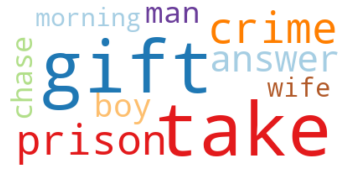


The coefficient  husband  with value  2.81 occurs in the following contexts: 
Displaying 5 of 2011 matches:
ting news Ellen is disappointed her husband is leaving but he is anxious to beg
len passes the time waiting for her husband sitting on the beach One day Hardin
he castle Ellen still longs for her husband who has recovered enough that he de
other After the tragic death of her husband John s wife decides her son Willie 
saving hoards most of the money her husband makes Marcus Schouler Trina s frust

The coefficient  sister  with value  2.75 occurs in the following contexts: 
Displaying 5 of 1986 matches:
med Harding Georg H Schnell and his sister Ruth Landshoff Hutter kisses his wi
n the beach One day Harding and his sister bring her the letter Hutter wrote w
ing them from his new home Hardings sister falls ill and Ellen watches as a fu
 moves to New York to live with her sister who after the mother s death raises
in the presence of Ulrich s younger sister Hertha Barbara Kent they

In [139]:
# Run analysis with min_df = 0.1 (instead of 5, which roughly corresponds to 400), and max_df = 0.9 (instead of 0.75) 
# --> overall accuracy decrease with lowered f1-scores for all
run_analysis(X=without_propn_processed_syn_1950_500, y=y_syn_1950_500, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=0.1, MAX_DF=0.9, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.65      0.63      0.64       347
    Passed (1)       0.73      0.74      0.73       462

      accuracy                           0.69       809
     macro avg       0.69      0.69      0.69       809
  weighted avg       0.69      0.69      0.69       809


Below the confusion matrix of the model is shown:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),220,127
Labeled Passed (1),121,341


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
1081,2.704522,sister
584,2.703023,husband
299,2.598683,daughter
753,2.502758,mother
436,2.244976,family
510,2.190117,girl
201,2.060780,child
1324,1.974236,woman
1019,1.832254,school
294,1.611318,dance



For a visual exploration of these most positive coefficient words, see the word cloud below


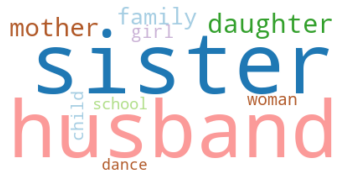


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
533,-1.116943,guy
281,-1.124703,crime
46,-1.186563,answer
885,-1.265053,prisoner
678,-1.314095,list
1313,-1.315338,wife
195,-1.373976,chase
393,-1.392844,enemy
139,-2.184262,boy
709,-2.824104,man



For a visual exploration of these most negative coefficient words, see the word cloud below


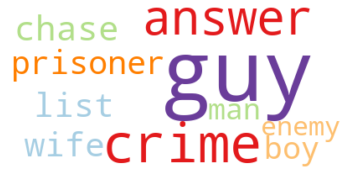


The coefficient  sister  with value  2.70 occurs in the following contexts: 
Displaying 5 of 1986 matches:
med Harding Georg H Schnell and his sister Ruth Landshoff Hutter kisses his wi
n the beach One day Harding and his sister bring her the letter Hutter wrote w
ing them from his new home Hardings sister falls ill and Ellen watches as a fu
 moves to New York to live with her sister who after the mother s death raises
in the presence of Ulrich s younger sister Hertha Barbara Kent they cut their 

The coefficient  husband  with value  2.70 occurs in the following contexts: 
Displaying 5 of 2011 matches:
ting news Ellen is disappointed her husband is leaving but he is anxious to beg
len passes the time waiting for her husband sitting on the beach One day Hardin
he castle Ellen still longs for her husband who has recovered enough that he de
other After the tragic death of her husband John s wife decides her son Willie 
saving hoards most of the money her husband makes Marcus Schouler Tr

In [140]:
# Run analysis with min_df = 0.05 (instead of 5, which roughly corresponds to 200), and max_df = 0.9 (instead of 0.75) 
# --> better than min_df = 0.1 but still performing worse overall
run_analysis(X=without_propn_processed_syn_1950_500, y=y_syn_1950_500, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=0.05, MAX_DF=0.9, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.65      0.63      0.64       347
    Passed (1)       0.73      0.75      0.74       462

      accuracy                           0.70       809
     macro avg       0.69      0.69      0.69       809
  weighted avg       0.70      0.70      0.70       809


Below the confusion matrix of the model is shown:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),220,127
Labeled Passed (1),117,345


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
2468,2.572850,mother
3499,2.553504,sister
1916,2.531418,husband
977,2.350450,daughter
1455,2.267491,family
1675,2.105670,girl
636,2.070642,child
4262,1.855203,woman
3339,1.791681,school
1891,1.591066,house



For a visual exploration of these most positive coefficient words, see the word cloud below


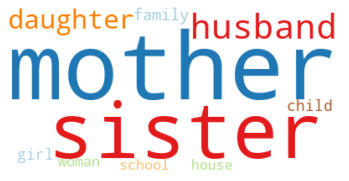


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
1760,-1.069818,guy
3918,-1.075591,thug
1641,-1.082249,gang
2161,-1.087852,knight
1321,-1.088296,enemy
618,-1.133065,chase
4239,-1.136732,wife
2921,-1.210942,prisoner
443,-2.218720,boy
2334,-2.901860,man



For a visual exploration of these most negative coefficient words, see the word cloud below


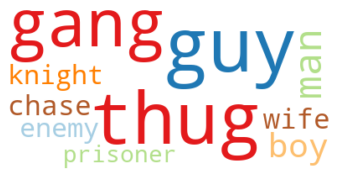


The coefficient  mother  with value  2.57 occurs in the following contexts: 
Displaying 5 of 6179 matches:
re as a nurse Elsie takes Cameron s mother who had traveled to Washington to t
nce on the perfidious advice of his mother and a modern story in which a young
 she is going to live with a loving mother Instead the abusive Louise uses her
he actor is behind bars in jail His mother and his girlfriend Mildred are cons
gh to support a family and with his mother s encouragement takes a train to jo

The coefficient  sister  with value  2.55 occurs in the following contexts: 
Displaying 5 of 1986 matches:
med Harding Georg H Schnell and his sister Ruth Landshoff Hutter kisses his wi
n the beach One day Harding and his sister bring her the letter Hutter wrote w
ing them from his new home Hardings sister falls ill and Ellen watches as a fu
 moves to New York to live with her sister who after the mother s death raises
in the presence of Ulrich s younger sister Hertha Barbara Kent they cut t

In [141]:
# Run analysis with min_df = 0.01 (instead of 5, which roughly corresponds to 40), and max_df = 0.9 (instead of 0.75) 
# --> better than min_df = 0.05 but still stays best with min_df = 5
run_analysis(X=without_propn_processed_syn_1950_500, y=y_syn_1950_500, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=0.01, MAX_DF=0.9, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### Synopsis analysis conclusion

We can conclude our analysis of synopsis data with the finding that all our trained models perform better than chance, so the Bechdel test rating can be predicted based on their synopsis texts. For this it is best to use the following settings (best being defined as not overfitting so not using unneccessary tokens, and preferring recall over precision for not passing labels):
* Use the subset of synopses of movies that are released after 1950 that have a length of more than 500 words (else these are the similar length as descriptions) 
* Preprocess the tokenized data with: lowercasing, lemmatization, punctuation removal, stop word removal, and word-type filtering with nouns, verbs, and adjectives (so without proper nouns)
* Take 20% of the data as testing data and the rest as training data
* Use a TF-IDF vectorizer on the tokenized words with min_df=0 and max_df=0.9, and train the logistic regression model on this

For ease, this best synopsis model is shown below:

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.66      0.64      0.65       347
    Passed (1)       0.74      0.75      0.74       462

      accuracy                           0.70       809
     macro avg       0.70      0.70      0.70       809
  weighted avg       0.70      0.70      0.70       809


Below the confusion matrix of the model is shown:


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),222,125
Labeled Passed (1),114,348


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
9431,2.524436,sister
6692,2.517612,mother
5153,2.449338,husband
3894,2.297416,family
2614,2.275674,daughter
4489,2.110209,girl
1721,2.050903,child
11605,1.808801,woman
9032,1.775727,school
5099,1.686498,house



For a visual exploration of these most positive coefficient words, see the word cloud below


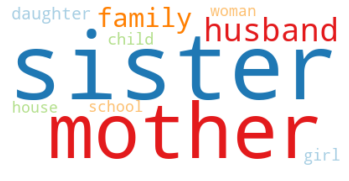


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
1677,-1.011145,chase
7922,-1.015673,prison
10544,-1.023148,thug
4714,-1.050587,guy
11547,-1.069389,wife
7923,-1.131689,prisoner
4401,-1.167619,gang
464,-1.218157,ape
1204,-2.214817,boy
6255,-2.919739,man



For a visual exploration of these most negative coefficient words, see the word cloud below


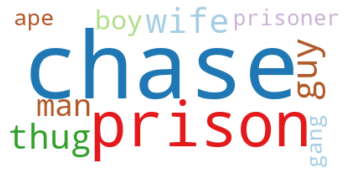


The coefficient  sister  with value  2.52 occurs in the following contexts: 
Displaying 5 of 1986 matches:
med Harding Georg H Schnell and his sister Ruth Landshoff Hutter kisses his wi
n the beach One day Harding and his sister bring her the letter Hutter wrote w
ing them from his new home Hardings sister falls ill and Ellen watches as a fu
 moves to New York to live with her sister who after the mother s death raises
in the presence of Ulrich s younger sister Hertha Barbara Kent they cut their 

The coefficient  mother  with value  2.52 occurs in the following contexts: 
Displaying 5 of 6179 matches:
re as a nurse Elsie takes Cameron s mother who had traveled to Washington to t
nce on the perfidious advice of his mother and a modern story in which a young
 she is going to live with a loving mother Instead the abusive Louise uses her
he actor is behind bars in jail His mother and his girlfriend Mildred are cons
gh to support a family and with his mother s encouragement takes a train 

In [142]:
# Run analysis for best performing model on synopsis data
run_analysis(X=without_propn_processed_syn_1950_500, y=y_syn_1950_500, raw_processed_texts=raw_processed_syn, 
             vectorizer = 'tf-idf', MIN_DF=0, MAX_DF=0.9, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

### Analyse description data

#### All descriptions, using count vectorizer on fully tokenized texts

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, stop word removal (except gendered pronouns), word-type filtering with proper nouns, nouns, verbs, and adjectives

Furthermore, the training and test dataset are established using 20% test data, a count vectorizer with min_df=5 and max_df=0.75 is used on the tokenized words, and logistic regression is trained on this

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.58      0.55      0.56       796
    Passed (1)       0.68      0.71      0.69      1076

      accuracy                           0.64      1872
     macro avg       0.63      0.63      0.63      1872
  weighted avg       0.64      0.64      0.64      1872


Below the confusion matrix of the model is shown:


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),435,361
Labeled Passed (1),317,759


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
3166,1.593840,hawaii
122,1.552256,advance
6314,1.338699,sin
1702,1.298620,dana
2509,1.297570,extraterrestrial
1870,1.282062,designer
1924,1.255787,diary
4741,1.235744,neo
2609,1.228994,female
5065,1.209605,particular



For a visual exploration of these most positive coefficient words, see the word cloud below


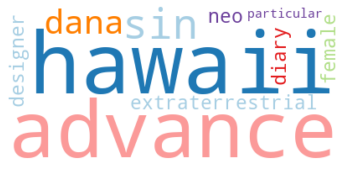


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
7301,-1.220842,usual
3217,-1.234416,helpless
4533,-1.286477,misfortune
5959,-1.319748,rope
7278,-1.338675,upcoming
5575,-1.355316,rafael
7240,-1.372421,unnamed
2194,-1.387541,eastern
6490,-1.454038,split
1815,-1.584534,deliver



For a visual exploration of these most negative coefficient words, see the word cloud below


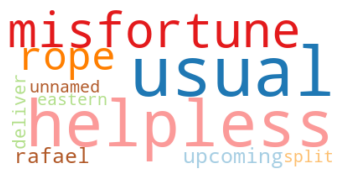


The coefficient  hawaii  with value  1.59 occurs in the following contexts: 
Displaying 5 of 17 matches:
Francisco for their tour of duty in Hawaii in December 1941 The attack on Pear
er and has ended up at Schofield in Hawaii His new captain Dana Holmes has hea
the Army and is happy to be back in Hawaii with his surfboard his beach buddie
jealous husband After a vacation in Hawaii Joanna Joey Drayton returns to her 
otels ambiance and entertainment of Hawaii Las Vegas Rome Tokyo All on the pre

The coefficient  advance  with value  1.55 occurs in the following contexts: 
Displaying 5 of 19 matches:
r s inimitable ethnic humor Despite advance warning to the police who seal off 
about Kris and his determination to advance the true spirit of Christmas among 
ic Lavinia does whatever she can to advance their relationship However Dr Slope
isease that normally takes years to advance but in his case seems to have affli
rn his timid advances As the allies advance Cesira decides to return to 

In [65]:
run_analysis(X=fully_processed_descr, y=y_descr, raw_processed_texts=raw_processed_descr, 
             vectorizer = 'count', MIN_DF=5, MAX_DF=0.75, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### All descriptions, using TF-IDF vectorizer on fully tokenized texts

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, stop word removal (except gendered pronouns), word-type filtering with proper nouns, nouns, verbs, and adjectives

Furthermore, the training and test dataset are established using 20% test data, a TF-IDF vectorizer with min_df=5 and max_df=0.75 is used on the tokenized words, and logistic regression is trained on this

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.68      0.58      0.62       796
    Passed (1)       0.72      0.80      0.75      1076

      accuracy                           0.70      1872
     macro avg       0.70      0.69      0.69      1872
  weighted avg       0.70      0.70      0.70      1872


Below the confusion matrix of the model is shown:


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),458,338
Labeled Passed (1),219,857


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
7598,4.458437,woman
2937,4.103510,girl
6328,3.551109,sister
1726,3.467929,daughter
4616,2.978923,mother
2546,2.493884,family
3380,2.405109,husband
2609,2.027391,female
1166,1.832779,child
5563,1.779178,rachel



For a visual exploration of these most positive coefficient words, see the word cloud below


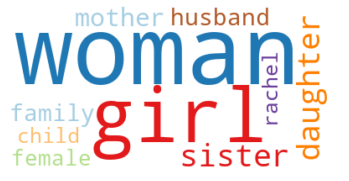


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
2938,-1.324482,girlfriend
904,-1.337417,bully
376,-1.351553,army
5256,-1.375556,plot
1608,-1.400336,crime
1050,-1.433483,case
3071,-1.510155,gun
1815,-1.514740,deliver
802,-2.620948,boy
4259,-3.253244,man



For a visual exploration of these most negative coefficient words, see the word cloud below


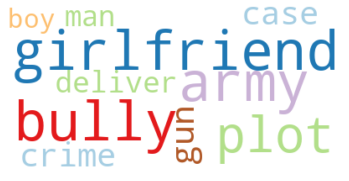


The coefficient  woman  with value  4.46 occurs in the following contexts: 
Displaying 5 of 1091 matches:
ng a bouquet of flowers to a topless woman who kisses his cheek A brief series 
 cinematograph colour animation of a woman and man at the beach Interior of Bar
ley hotmail com Presumably the first woman ever to appear in a Kinetoscope film
etoscope film and possibly the first woman to take part in a motion picture in 
he picture was being taken A man and woman festively dressed in costumes are dr

The coefficient  girl  with value  4.10 occurs in the following contexts: 
Displaying 5 of 933 matches:
necessary Geraldine Jerry Holbrook a girl of Eastern birth decides to start a 
n Mephistopheles conjures up a young girl and various supernatural creatures o
magic transforming a poor and ragged girl to a fine aristocratic Lady at the K
 young couple coming up the road The girl s shoe string came loose and her com
esented as being engaged to a pretty girl who is accustomed to take a ri

In [66]:
run_analysis(X=fully_processed_descr, y=y_descr, raw_processed_texts=raw_processed_descr, 
             vectorizer = 'tf-idf', MIN_DF=5, MAX_DF=0.75, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### Same settings as used for best synopsis model but than for description data and not filtered on its description length

This analysis uses for preprocessing: lowercasing, lemmatization, punctuation removal, stop word removal (except gendered pronouns), word-type filtering with nouns, verbs, and adjectives (so without proper nouns)

Furthermore, the training and test dataset are established using 20% test data, a TF-IDF vectorizer with min_df=0 and max_df=0.9 is used on the tokenized words, and logistic regression is trained on this

In [143]:
# Here take the standard settings, but still filter on word types (now only verb, noun, adj) and remove stop words
_, without_propn_processed_descr = tokenize(df_column=None, processed_texts = raw_processed_descr, 
                                                remove_punctuation=True, to_lowercase=True, stop_words=stop_list, 
                                                word_types=['VERB', 'NOUN', 'ADJ'], to_lemma=True)

In [145]:
# Reindex the all description data such that it corresponds to the indices of the
# tokenized texts (as there are a few less descriptions than movies)
df_descr.reset_index(inplace=True)

In [148]:
# Subset the tokenized description data and labels into the movies after 1950 
list_indices_descr_1950 = list(df_descr[df_descr.year >= 1950].index.values)
without_propn_processed_descr_1950 = [without_propn_processed_descr[i] for i in list_indices_descr_1950]
y_descr_1950 = [y_descr[i] for i in list_indices_descr_1950]

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Below the classification report of the model is shown:
                precision    recall  f1-score   support

Not passed (0)       0.65      0.46      0.54       736
    Passed (1)       0.67      0.82      0.74      1004

      accuracy                           0.67      1740
     macro avg       0.66      0.64      0.64      1740
  weighted avg       0.66      0.67      0.65      1740


Below the confusion matrix of the model is shown:


,Predicted Not passed (0),Predicted Passed (1)
Labeled Not passed (0),339,397
Labeled Passed (1),185,819


Below the most positive coefficients with their corresponding words are visualised,
 which are associated with the label  Passed (1)


,coef,word
15250,4.248791,woman
12393,3.793837,sister
5764,3.568510,girl
3349,3.513581,daughter
8774,3.108982,mother
6611,2.547109,husband
9693,2.098485,parent
5101,2.027806,female
2270,1.907682,child
4993,1.844528,family



For a visual exploration of these most positive coefficient words, see the word cloud below


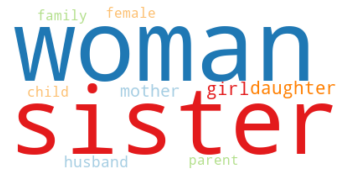


Below the most negative coefficients with their corresponding words are visualised,
 which are associated with the label  Not passed (0)


,coef,word
11909,-1.264786,scientist
5641,-1.291202,gang
745,-1.298811,army
198,-1.306600,actor
1138,-1.327128,baseball
6042,-1.353113,gun
7501,-1.547223,kidnap
2036,-1.675875,case
1605,-2.210785,boy
8130,-3.270119,man



For a visual exploration of these most negative coefficient words, see the word cloud below


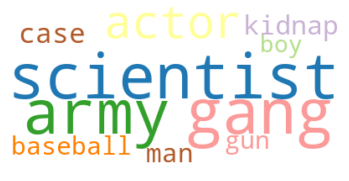


The coefficient  woman  with value  4.25 occurs in the following contexts: 
Displaying 5 of 1091 matches:
ng a bouquet of flowers to a topless woman who kisses his cheek A brief series 
 cinematograph colour animation of a woman and man at the beach Interior of Bar
ley hotmail com Presumably the first woman ever to appear in a Kinetoscope film
etoscope film and possibly the first woman to take part in a motion picture in 
he picture was being taken A man and woman festively dressed in costumes are dr

The coefficient  sister  with value  3.79 occurs in the following contexts: 
Displaying 5 of 542 matches:
 s Calaveras County When Lawrence s sister dies her daughter spends the little
an takes her baby boy Willie to her sister s house in New York hoping he will 
r hopelessly in love with her elder sister s boyfriend tries to make him notic
who it was All seems well until her sister Joan returns from a trip and happil
brother Mike and Matt s straitlaced sister Molly From their teen aged 

In [149]:
run_analysis(X=without_propn_processed_descr_1950, y=y_descr_1950, raw_processed_texts=raw_processed_descr, 
             vectorizer = 'tf-idf', MIN_DF=0, MAX_DF=0.9, 
             test_size = 0.2, max_iter=100, labels=labels, 
             n_coef_context=5, n_coef_context_matches=5, n_coef_wordcloud=10)

#### Description analysis conclusion

We haven't done as in depth analysis of description data as we did on synopsis data, but these all seem to still perform above chance level and not much worse than training on the longer synopsis data. So probably with these fewer words it already has a relatively good grasp of what the movie is in genre/contents about. Mainly the most positive valued coefficients have similar words surrounding family and womanhood in description and synopsis models. Note also that the exact same settings for description models as the best model of synopsis data used does not per se correspond to a better description model. The main reason for using synopsis data over description data is that there is more information to make more accurate predictions, especially with respect to the not passing movies accuracy (which is close to chance with description data but most important for our model to classify correctly).